## Machine Learning Coursework

#### Author - Victoria Moulds

The notebook takes approximately 2hrs to run due to the random grid search cross validation code for question 1.

Reference material I used for answering the questions are noted at the end of the notebook.

## Part 1 - Supervised Learning 

#### Data Set: Enron email dataset containing spam and not spam emails

#### Goal: Supervised classification pipeline to classify emails as spam or not spam

In [1]:
#Libraries required to answer this question
import pandas as pd
import numpy as np
from time import time
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Preprocessing 

The next code cell contains functions which perform the following steps:

1) Read in the enron spam pre-processed data sets into a Pandas DataFrame.  The data has been downloaded from the following URL and unzipped into Data/ folder within the same directory as this notebook
    
        Dataset URL: http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/index.html  

2) Clean data removing empty rows and duplicate rows if there are any  

3) Splits the dataset into a training set and test set using stratify to ensure same distribution of target classes in train and test datasets 

4) Checks for class imbalance that might bias the data set 

5) Performs statistical checks on the training and test sets including counts of spam versus non-spam emails

These functions will be used in the later sections for exploratory data analysis as well as to train and build the final model.

In [2]:
##################################################################################################################
#   Define useful functions for reading and cleaning the email data
##################################################################################################################

def get_enron_email_data():
    """
        return: pandas dataframe containing all enron email data
    """
    X, y = [], []
    for i in range(1,7):
        emails = load_files(container_path=f"Data/enron{i}", 
                            categories=['ham', 'spam'],
                            shuffle=True, random_state=42)
        X = np.append(X, emails.data)
        y = np.append(y, emails.target)
    classes = emails.target_names
    z = [classes[int(item)] for item in y] 
    print(f"Class X[0]: {y[0]} ({classes[int(y[0])]})")
    data_dict = {"Email": X, "Response":y, "Class":z}
    data_df = pd.DataFrame(data_dict)
    return data_df   
    
def clean_data(data):
    """
        data: pandas dataframe containing enron emails 
        
        return: pandas dataframe with missing and duplicated data removed
    """
    print('Initial shape of email data: ', data.shape)
    data = data.replace('', np.nan) #Replace empty strings with NaN
    print('Missing data shape: ', data[data.isnull().any(axis=1)].shape)
    data_null_removed = data.dropna()
    print('Removed missing rows so data now has shape: ', data_null_removed.shape)
    cleaned_data = data_null_removed.drop_duplicates(subset="Email")
    print('Removed duplicates so data now has shape: ', cleaned_data.shape)
    return cleaned_data
    
    
def enron_email_cleaned_dataset():
    """
        return: cleaned_email_df - pandas dataframe containing cleaned eron 
                                    email data
                train_data - pandas dataframe containing a subset of cleaned 
                                emails for model training 
                test_data - pandas dataframe containing a subset of cleaned 
                                email for model testing
    """
    email_df = get_enron_email_data()
    cleaned_email_df = clean_data(email_df)
    print("Cleaned data statistics")
    print(cleaned_email_df[['Response','Class']].describe(include='all'))
    return cleaned_email_df


def print_train_test_statistics(train_data, test_data):
    """
        train_data: Pandas dataframe containing training dataset
        test_data: Pandas dataframe containing test dataset
    """
    print("\n\n")
    print("Training data statistics:")
    print(train_data.describe())
    print('Training data non-spam (0.0) versus spam (1.0) counts: ')
    print(train_data.groupby('Response').count())
    print("\n\n")
    print("Test data statistics:")
    print(test_data.describe())
    print('Test data non-spam (0.0) versus spam (1.0) counts: ')
    print(test_data.groupby('Response').count())


def create_and_save_train_test_data(X, y):
    """
        X: Processed email data
        y: Response data i.e. 0.0 for non-spam and 1.0 for spam
        
        return: train_df which is a pandas dataframe containing a 
                    labelled training email data set
                test_df which is a pandas dataframe containing a 
                    labelled test email data set
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.3, 
                                                        random_state=42, 
                                                        stratify=y)
    train_df = pd.DataFrame({"Email": X_train, "Response": y_train})
    train_df.to_csv('Data/email_train.csv')
    test_df = pd.DataFrame({"Email": X_test, "Response": y_test})
    test_df.to_csv('Data/email_test.csv')
    print_train_test_statistics(train_df, test_df)
    return train_df, test_df    

In [3]:
cleaned_email_data = enron_email_cleaned_dataset()
train_data, test_data = create_and_save_train_test_data(cleaned_email_data.Email, 
                                                        cleaned_email_data.Response)

Class X[0]: 0.0 (ham)
Initial shape of email data:  (33716, 3)
Missing data shape:  (0, 3)
Removed missing rows so data now has shape:  (33716, 3)
Removed duplicates so data now has shape:  (30494, 3)
Cleaned data statistics
            Response  Class
count   30494.000000  30494
unique           NaN      2
top              NaN    ham
freq             NaN  15910
mean        0.478258    NaN
std         0.499535    NaN
min         0.000000    NaN
25%         0.000000    NaN
50%         0.000000    NaN
75%         1.000000    NaN
max         1.000000    NaN



Training data statistics:
           Response
count  21345.000000
mean       0.478238
std        0.499538
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Training data non-spam (0.0) versus spam (1.0) counts: 
          Email
Response       
0.0       11137
1.0       10208



Test data statistics:
          Response
count  9149.000000
mean      0.478304
std       0.499556
min      

#### Analysis 

The results above show that there were 3222 duplicated emails that have been removed from the dataset.  Using the stratified method to split the data has resulted in the training and test datasets having similar distributions of non-spam and spam emails.  The training dataset has 52% non-spam emails and 48% are spam which is the same as the test dataset which has ~48% spam and ~52% non-spam.  

### Feature Extraction

Most algorithms expect numerical feature vectors and so the words in the emails will need to be transformed.

In this case the emails will be firstly transformed into a bag of words and then weighted according to term-frequency times inverse document-frequency (tf–idf). 

These functions will be used in the later sections for exploratory data analysis as well as to train and build the final model.

In [4]:
##################################################################################################################
#   Define useful functions for feature extraction
##################################################################################################################

def feature_extraction_pipeline(params):
    """
        params: dictionary containing parameter settings
        
        return: pipe which contains feature transformer tf-idf 
                    vectorizer for converting text to vector
    """
    if params is None:
        pipe = make_pipeline(TfidfVectorizer(encoding='latin-1'))
    else:
        pipe = make_pipeline(TfidfVectorizer(encoding='latin-1', 
                                             stop_words=params['stop_words'],
                                             max_features=params['max_features'], 
                                             ngram_range=params['ngram_range'],
                                             use_idf=params['use_idf'], 
                                             norm=params['norm']))
    return pipe


In [5]:
# Test the functions work for train data and test data as expected
pipe = feature_extraction_pipeline(None)
tfidf_train_data = pipe.fit_transform(train_data.Email) 
tfidf_test_data = pipe.transform(test_data.Email)

print('Training data shape after feature extraction: ', tfidf_train_data.shape)
print('\n')
print('Test data shape after feature extraction: ', tfidf_test_data.shape)

Training data shape after feature extraction:  (21345, 134037)


Test data shape after feature extraction:  (9149, 134037)


### Exploratory Analysis

In this section the entire email data is explored and analysed to determine the following:

    1) Top 20 words in spam vs non-spam emails with stop gap words included
    
    2) Top 20 words in spam vs non-spam emails with stop gap words removed

    3) Email length distribution in spam vs non-spam emails 
    

In [6]:
##################################################################################################################
#   Define useful functions for exploratory analysis
##################################################################################################################

def get_spam_and_nonspam_emails(data):
    """
        data: input pandas dataframe

        return: spam_emails which is pandas dataframe only containing 
                    spam emails
                nonspam_emails which is pandas dataframe only containing 
                    non-spam emails
    """
    spam_emails = data[data['Response'] == 1.0]
    nonspam_emails = data[data['Response'] == 0.0]
    return spam_emails, nonspam_emails

def top_n_words(data, n, stop_words=None):
    """
        data: input data
        n: number of highest frequency words to return

        return: list containing n words with the highest frequency
    """
    vectorizer = CountVectorizer(encoding='latin-1', stop_words=stop_words)
    word_cv = vectorizer.fit_transform(data)
    word_sum = word_cv.sum(axis=0) 
    word_freq = [(word, word_sum[0, idx]) for word, idx in 
                 vectorizer.vocabulary_.items()]
    sorted_word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    top_n_words_df = df = pd.DataFrame(sorted_word_freq[:n], 
                                       columns = ["Word", "Count"])
    return top_n_words_df

def plot_top_n_words(spam_data, nonspam_data, n, stop_words, fig_title):
    """
        spam_data: pandas dataframe containing spam data
        nonspam_data: pandas dataframe containing non spam data
        n: number of highest frequency words to return
        stop_words: string determining stop_words setting
        fig_title: string that represents title for plot
    """
    top_n_words_spam_emails = top_n_words(spam_emails.Email, n, stop_words)
    top_n_words_nonspam_emails = top_n_words(nonspam_emails.Email, n, stop_words)

    fig, ax =plt.subplots(2,1,figsize=(15,15))
    fig.suptitle(fig_title)
    sns.barplot(x="Count", y="Word", data=top_n_words_spam_emails, ax=ax[0])
    sns.barplot(x="Count", y="Word", data=top_n_words_nonspam_emails, ax=ax[1])
    ax[0].set_title('Spam emails - Top ' + str(n) + ' words')
    ax[1].set_title('Non-Spam emails - Top ' + str(n) + ' words')
    fig.show()
    
def calculate_email_length_metrics(data):
    """
        data: Pandas dataframe containing data
        
        return: data which is Pandas dataframe containing 
                    columns that show number of characters or 
                    words in the email
    """
    data['Email_Num_Characters'] = data.apply(lambda row: len(row['Email']), 
                                              axis=1)
    data['Email_Num_Words'] = data.apply(lambda row: len(row['Email'].split()), 
                                         axis=1)
    return data

def plot_email_length_metrics(email_data):
    """
        email_data: Pandas dataframe containing email data 
    """
    fig, ax =plt.subplots(1,2,figsize=(15,8))
    fig.suptitle('Email Length Distribution Plots')
    sns.boxplot(x="Class", y="Email_Num_Words", data=email_data, ax=ax[0])
    sns.boxplot(x="Class", y="Email_Num_Characters", data=email_data, ax=ax[1])
    ax[0].set_title('Email Word Count Distribution')
    ax[1].set_title('Email Character Count Distribution')
    fig.show()

In [7]:
spam_emails, nonspam_emails = get_spam_and_nonspam_emails(cleaned_email_data)
print(spam_emails.groupby('Response').count())
print(nonspam_emails.groupby('Response').count())

          Email  Class
Response              
1.0       14584  14584
          Email  Class
Response              
0.0       15910  15910


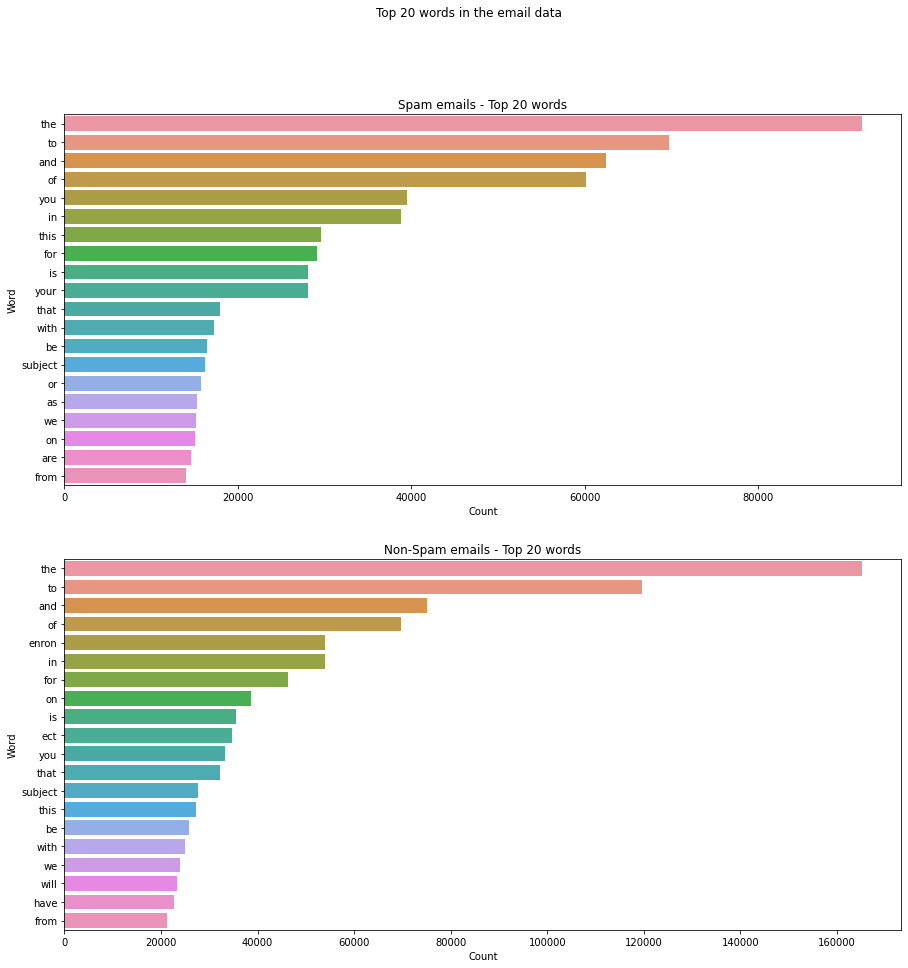

In [8]:
plot_top_n_words(spam_emails, nonspam_emails, 20, None, 
                 'Top 20 words in the email data')

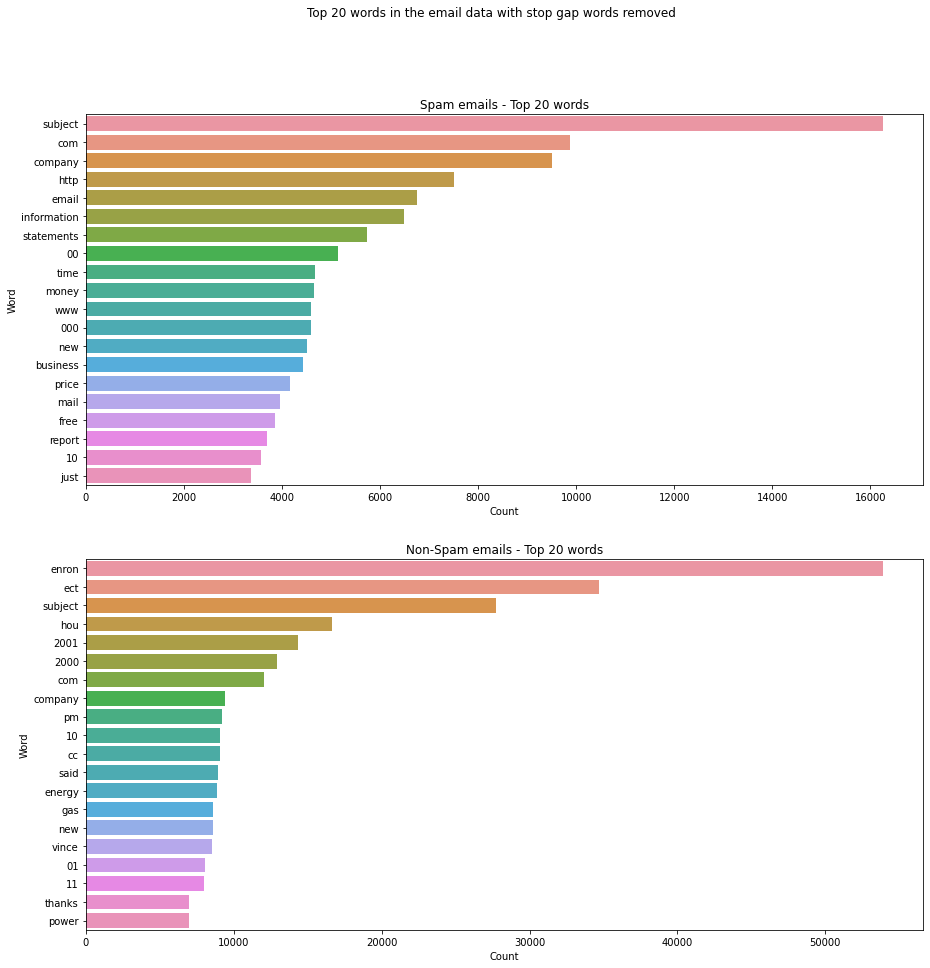

In [9]:
plot_top_n_words(spam_emails, nonspam_emails, 20, 'english', 
                 'Top 20 words in the email data with stop gap words removed')

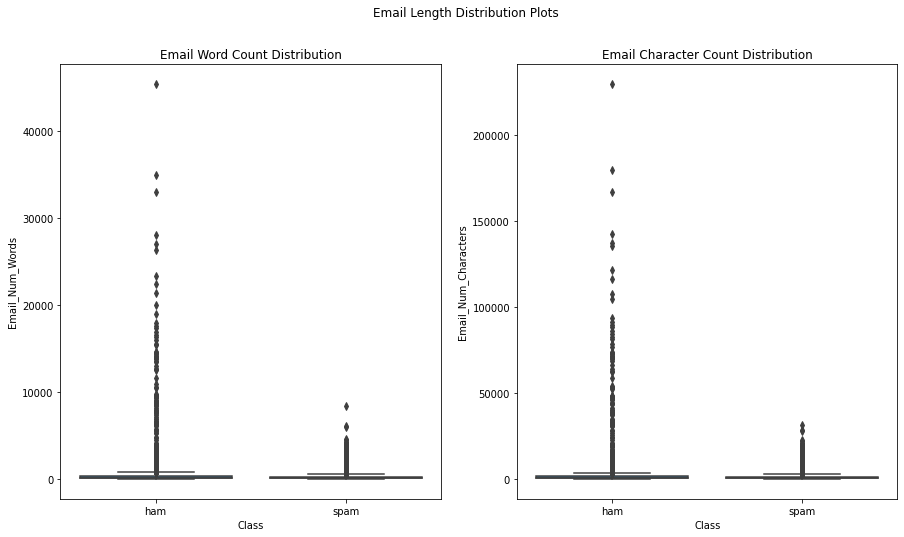

In [10]:
email_metrics = calculate_email_length_metrics(cleaned_email_data)
plot_email_length_metrics(email_metrics)

In [11]:
metric_columns = ['Class', 'Email_Num_Characters', 'Email_Num_Words']
email_metrics[metric_columns].groupby('Class').describe()

Email_Num_Characters                                                \
                     count         mean          std   min    25%    50%   
Class                                                                      
ham                15910.0  1659.513828  5439.580948  14.0  355.0  815.0   
spam               14584.0  1346.824534  1964.198815  11.0  366.0  672.0   

                        Email_Num_Words                                      \
          75%       max           count        mean          std  min   25%   
Class                                                                         
ham    1711.0  230145.0         15910.0  347.356757  1075.104322  2.0  74.0   
spam   1420.5   31407.0         14584.0  262.509188   382.220373  1.0  72.0   

                              
         50%    75%      max  
Class                         
ham    175.0  369.0  45451.0  
spam   138.0  277.0   8402.0

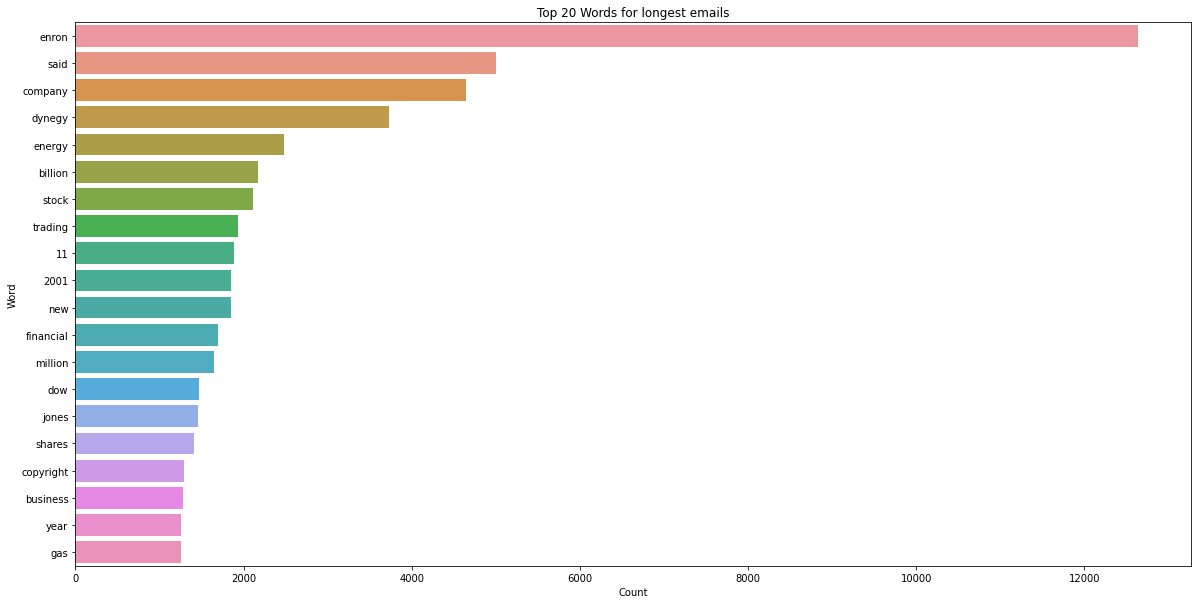

In [12]:
## Investigate the longer emails to understand them better
longest_email_data = email_metrics[email_metrics['Email_Num_Words'] > 10000]
top_20_words_longest_emails = top_n_words(longest_email_data.Email, 20, 'english')
plt.figure(figsize=(20,10))
plt.title('Top 20 Words for longest emails')
sns.barplot(x="Count", y="Word", data=top_20_words_longest_emails)
plt.show()

#### Exploratory Analysis Summary

The above analysis show the following:

* Spam and non-spam emails have similar top 20 words when stop gap words are NOT removed 


* When stop gap words are removed then spam emails differ greatly in the top words compared to non-spam emails.  For example the bar plot above shows that spam emails have frequent words like money, time, business and free which are not seen at all in the top 20 for non-spam emails.


* The box plots and statistics describing the length of spam and non-spam emails show that spam emails tend to be shorter compared to non-spam emails.  The average word count of a spam email is approximately 262 words compared to the 347 for non-spam emails.


* The emails with word count > 10000 are all non-spam emails and can see from the bar plot of the top 20 words in these emails that they seem to relate to finance and the business.


This data analysis is interesting as it shows there is a distinction between spam and non-spam emails based on the email length and also on the words that tend to appear more frequently in the emails.  It is also interesting that the longest non-spam emails seem to pertain more to financial information compared to the overall collection of non-spam emails.  

### Supervised Classification Model 

In this section I am going to compare the following 2 models:

* Support vector machine (SVM)

* K nearest neighbour (KNN)

As part of this analysis I will be using random search cross validation on the train dataset to tune the hyperparameters for each of the models as well as the feature extraction hyperparameters.  Random search will not exhaustively search the parameter space like grid search but random search is less time consuming which is why it was choosen. 

Plots showing the performance of a subset of models tested during the grid search will be shown.

The most performant model will be used to build the final model which will then be tested on the test dataset.

In [13]:
##################################################################################################################
#     Grid search functions for hyperparameter tuning
##################################################################################################################

def print_best_parameters_from_random_search(random_search, parameters):
    """
        random_search: random search object
        parameters: dictionary of search parameters
    """
    print("Best score: %0.3f" % random_search.best_score_)
    print("Best parameters set:")
    best_parameters = random_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

def random_search_svm_classifier_model(data, scoring_data):
    """
        Random serach method to find the best hyperparameters for the svm model.
        
        data: pandas dataframe containing emails and spam / non-spam label
        scoring_data: list containing scoring metrics to be used in the grid search
        
        return: grid_search object
    """
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(encoding='latin-1')),
        ('clf', svm.SVC()),
    ])

    parameters = {
        'tfidf__stop_words': ('english', None),
        'tfidf__max_features': (None, 10000, 50000),
        'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
        'tfidf__use_idf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
        'clf__kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
        'clf__gamma': ('scale', 'auto'),
    }
    
    print("Performing SVM random search...")
    t0 = time()
    
    random_search = RandomizedSearchCV(estimator=pipeline, 
                                       param_distributions=parameters, 
                                       n_iter=20,
                                       scoring=scoring_data, 
                                       refit='roc_auc', 
                                       n_jobs=-1, verbose=1, cv=5, 
                                       random_state=42)    
    random_search.fit(data.Email, data.Response)
    
    print("Completed SVM random search in %0.3fs" % (time() - t0))
    
    print_best_parameters_from_random_search(random_search, parameters)
    return random_search


def random_search_knn_model(data, scoring_data):
    """
        Random serach method to find the best hyperparameters for the knn model.
        
        data: pandas dataframe containing emails and spam / non-spam label
        scoring_data: list containing scoring metrics to be used in the grid 
                        search
        
        return: grid_search object
    """
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(encoding='latin-1')),
        ('clf', KNeighborsClassifier()),
    ])

    parameters = {
        'tfidf__stop_words': ('english', None),
        'tfidf__max_df': (0.5, 0.75, 1.0),
        'tfidf__max_features': (None, 5000, 10000, 50000),
        'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
        'tfidf__use_idf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
        'clf__weights': ('uniform', 'distance'),
        'clf__n_neighbors': (1, 3, 5, 7, 9),
        'clf__algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'), 
        'clf__p': (1, 2),
    }
    
    random_search = RandomizedSearchCV(estimator=pipeline, 
                                       param_distributions=parameters, 
                                       n_iter=20, 
                                       scoring=scoring_data, 
                                       refit='roc_auc', 
                                       n_jobs=-1, 
                                       verbose=1, cv=5, 
                                       random_state=42)

    print("Performing KNN random search")
    t0 = time()
    random_search.fit(data.Email, data.Response)
    print("Completed KNN random search in %0.3fs" % (time() - t0))
    
    print_best_parameters_from_random_search(random_search, parameters)
    return random_search


def plot_model_results(random_search, title):
    """
        random_search: grid search object
        title: string that will be used for the title of the plot
        
    """
    search_results = pd.DataFrame(random_search.cv_results_)
    fig, ax =plt.subplots(2,2,figsize=(15,8))
    fig.suptitle(title)
    sns.lineplot(data=search_results, x=search_results.index, 
                 y="mean_test_accuracy", ax=ax[0,0])
    sns.lineplot(data=search_results, x=search_results.index, 
                 y="mean_test_roc_auc", ax=ax[0,1])
    sns.lineplot(data=search_results, x=search_results.index, 
                 y="mean_test_precision", ax=ax[1,0])
    sns.lineplot(data=search_results, x=search_results.index, 
                 y="mean_test_recall", ax=ax[1,1])
    ax[0,0].set_title("Models Mean Test Accuracy Score")
    ax[0,1].set_title("Models Mean Test AUC Score")
    ax[1,0].set_title("Models Mean Test Precision Score")
    ax[1,1].set_title("Models Mean Test Recall Score")
    fig.show()
        

In [14]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
svm_random_search = random_search_svm_classifier_model(train_data, scoring)

Performing SVM random search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 52.0min finished


Completed SVM random search in 3257.268s
Best score: 0.999
Best parameters set:
	clf__gamma: 'auto'
	clf__kernel: 'linear'
	tfidf__max_features: 50000
	tfidf__ngram_range: (1, 2)
	tfidf__norm: 'l2'
	tfidf__stop_words: None
	tfidf__use_idf: True


In [15]:
knn_random_search = random_search_knn_model(train_data, scoring)

Performing KNN random search
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.9min finished


Completed KNN random search in 903.884s
Best score: 0.997
Best parameters set:
	clf__algorithm: 'ball_tree'
	clf__n_neighbors: 5
	clf__p: 1
	clf__weights: 'distance'
	tfidf__max_df: 0.5
	tfidf__max_features: None
	tfidf__ngram_range: (1, 2)
	tfidf__norm: 'l1'
	tfidf__stop_words: None
	tfidf__use_idf: True


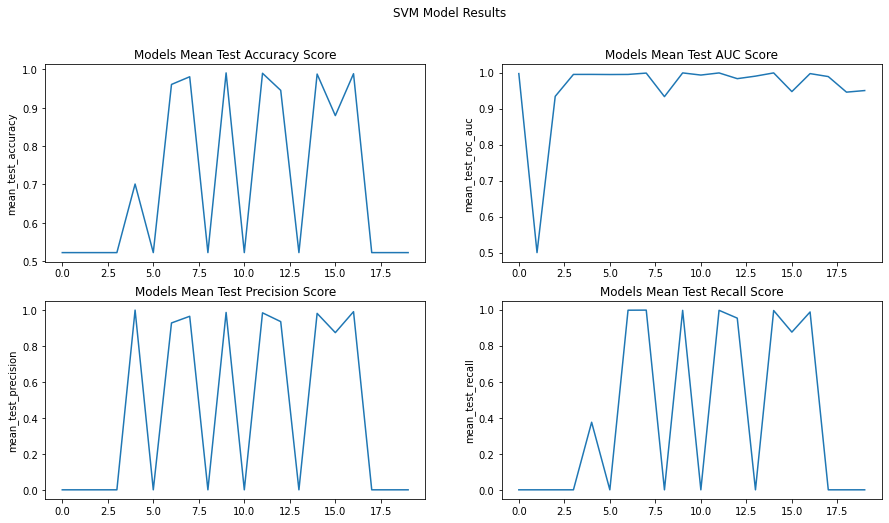

In [16]:
plot_model_results(svm_random_search, "SVM Model Results")

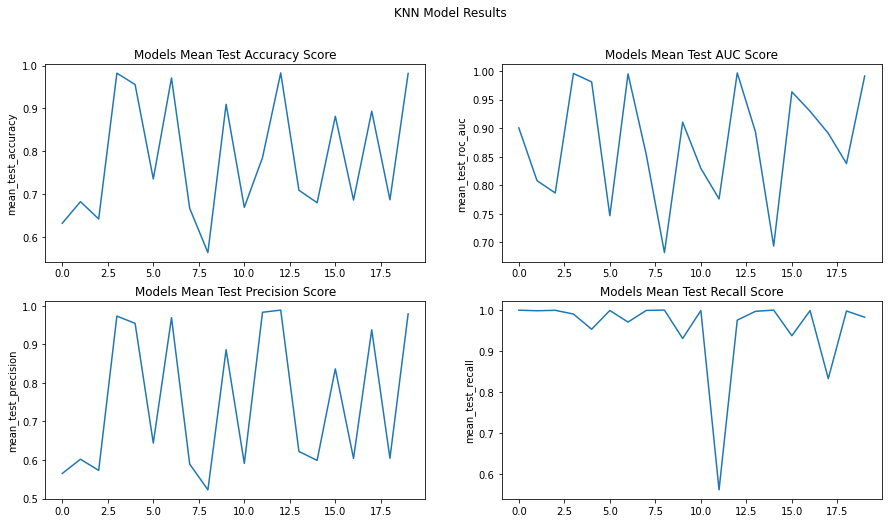

In [17]:
plot_model_results(knn_random_search, "KNN Model Results")

#### Model Search Analysis 

A random search was performed for a SVM model and KNN model to determine which performed better for different hyperparameter combinations.

From the SVM scoring metrics plot above can see that several of the models performed well for all four of the scoring metrics such as model 9, model 14, and model 16.  

For the KNN model the scoring metrics plot above also show several of the models performing well for 3 of the scoring metrics accuracy, auc and precision e.g. model 3, model 6 and model 12.  However, the recall score appears to be out of sync with the other metrics and it looks to show model model 10, model 13 and model 14 performing well. 

The best model found from the random search cross-validation for SVM has an AUC score of 0.999 while the KNN best model has a slightly lower AUC score of 0.997. 

Given the fact that the SVM model appeared to perform well for all 4 scoring metrics from the plots above and also has the higher AUC scores between the 2 models then it will be used to build the final model based.  The final model will be built using the parameters for the best SVM model as noted below:

    Feature Extraction parameters:
        max_features: 50000
        ngram_range: (1, 2)
        stop_words: None
        norm: 'l2'
        use_idf: True

	SVM Model parameters:
        gamma: 'auto'
        kernel: 'linear'


In [61]:
def get_feature_extraction_params():
    """
        return: dictionary containing the chosen optimal 
                    hyperparameters for count_vector
    """
    return {'stop_words': None, 'max_features': 50000, 
            'ngram_range': (1,2), 'use_idf': True, 
            'norm': 'l2'}

def build_final_model(X, y):
    """
        X: email feature extraction data
        y: response determining if spam or non-spam
        
        return: model - the built model
    """    
    model = svm.SVC(kernel='linear', gamma='auto')
    model.fit(X, y)
    return model

def print_model_classification_report(model, X_test, y_test):
    """
        model: the final model object built using the optimal parameters
        test_data: the test data set that was held out from training 
                        and building the model
    """
    model_prediction = model.predict(X_test)
    target_names = ['class 0 - ham', 'class 1 - spam']
    print(classification_report(y_test, model_prediction, 
                                target_names=target_names))
    
def save_model(model):
    """
        model: the final model object built using the optimal parameters
        
        Outputs the model to a pickle file
    """
    print('Saving final model..')
    filename = 'finalized_model.sav'
    pickle.dump(model, open(filename, 'wb'))
    print('Saved final model')
    
def build_validate_and_save_final_model():
    """
        Overall function to build, validate and save the final model
    """
    training_data = pd.read_csv('Data/email_train.csv') 
    print('Read in training data and it has shape - ', training_data.shape)
    feature_pipeline = feature_extraction_pipeline(get_feature_extraction_params())
    tfidf_train_data = feature_pipeline.fit_transform(training_data.Email) 
    print('Feature Extraction - Train Data Shape: ', tfidf_train_data.shape)
    final_model = build_final_model(tfidf_train_data, training_data['Response'])
    testing_data = pd.read_csv('Data/email_test.csv')
    print('Read in testing data and it has shape - ', testing_data.shape)
    tfidf_test_data = feature_pipeline.transform(test_data.Email)
    print('Feature Extraction - Test Data Shape: ', tfidf_test_data.shape)
    print_model_classification_report(final_model, tfidf_test_data, 
                                      testing_data['Response'])
    save_model(final_model)


In [62]:
build_validate_and_save_final_model()

Read in training data and it has shape -  (21345, 3)
Feature Extraction - Train Data Shape:  (21345, 50000)
Read in testing data and it has shape -  (9149, 3)
Feature Extraction - Test Data Shape:  (9149, 50000)
                precision    recall  f1-score   support

 class 0 - ham       0.99      0.99      0.99      4773
class 1 - spam       0.99      0.99      0.99      4376

      accuracy                           0.99      9149
     macro avg       0.99      0.99      0.99      9149
  weighted avg       0.99      0.99      0.99      9149

Saving final model..
Saved final model


### Conclusions 

In this analysis two classification models, SVM and KNN, were compared to see which was the better for classifying spam and non-spam emails.  Random search with cross validation technique was employed to randomly search the parameter space to find the best hyperparameters for the SVM and KNN models in a timely manner.  The best SVM model was then compared against the best KNN model using AUC score and it was found that best SVM model outperformed the best KNN model.  The final model was then built using the optimal SVM model.

The test data set that was initially removed from the original data was then used to validate the final model performance.  The classification report printed above shows that the final model has an overall accuracy of 0.99 which means that it will correctly classify 99 out of 100 emails.  

The precision and recall metrics for the two classes - spam and non-spam are also displayed.  These metrics show that on average 1 out of 100 spam emails are likely to be misclassified and in fact be non-spam.  Similarly, 1 out of 100 non-spam emails are likely to be misclassified as spam.  This mirrors recall metrics where 1 out of 100 spam emails are likely to be a false negative and in fact be misclassified as non-spam.

This models appears to have good performance metrics.  In order, to try and get a better model then a grid search to fully explore the parameter space or another model such as decision tree could be investigated.

## Part 2 - Bayesian Machine Learning 

Data Set: 'Movehub Rating' data that scores cities based on features that quantify the quality of life and cost of living

Goal: Using Bayesian linear regression determing how the 'Movehub Rating' score is impacted by various features

### Setup 

The next code cell contains a function that does the following:

1) Read in the data sets

2) Fix the invalid cinema ticket price for Riyadh 

3) Merge the data sets into 1 dataframe

4) Normalise the data 

In [20]:
## Libraries required for this question
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [21]:
def setup():
    """ 
        return: pandas dataframe containing the merged, cleaned 
                and normalised dataset
    """
    cost_living_df = pd.read_csv('Data/movehubcostofliving.csv')
    quality_life_df = pd.read_csv('Data/movehubqualityoflife.csv')
    ## Fix the outlier in the data
    cost_living_df['Cinema'] = cost_living_df.apply(lambda row: 10.00
                                                       if row['City'] == 'Riyadh' 
                                                       else row['Cinema'], axis=1)
    ## Create a single dataframe containing quality of life & cost of living data sets
    merged_df = pd.merge(cost_living_df, quality_life_df, on="City")
    merged_df.set_index('City', inplace=True)
    ## Normalise the variables 
    normalise_transformer = ColumnTransformer([('normalise', MinMaxScaler(),
                                                make_column_selector(
                                                    dtype_include=np.number))])
    normalised_df = pd.DataFrame(normalise_transformer.fit_transform(merged_df),
                                 index=merged_df.index, 
                                 columns = merged_df.columns)
    return normalised_df

    
movehub_data = setup()
movehub_data.head()

Cappuccino    Cinema      Wine  Gasoline  Avg Rent  \
City                                                           
Lausanne    0.669154  0.820396  0.261032  0.771605  0.323082   
Zurich      0.701493  0.820396  0.261032  0.765432  0.457847   
Geneva      0.582090  0.847032  0.348043  0.746914  0.504350   
Basel       0.756219  0.767123  0.217319  0.728395  0.309960   
Perth       0.599502  0.732116  0.330974  0.555556  0.397933   

          Avg Disposable Income  Movehub Rating  Purchase Power  Health Care  \
City                                                                           
Lausanne               1.000000        0.681206        0.987364     0.599228   
Zurich                 0.983461        0.648305        0.856441     0.765340   
Geneva                 0.915958        0.583001        0.641629     0.719420   
Basel                  0.899082        0.606181        0.839944     0.784108   
Perth                  0.781070        0.884845        0.652042     0.795022   

          Pollution  Quality of Life  Crime Rating  
City                                                
Lausanne   0.948063         0.733319      0.345215  
Zurich     0.195196         1.000000      0.081473  
Geneva     0.318438         0.836428      0.590808  
Basel      0.640338         0.895919      0.248205  
Perth      0.254599         0.748542      0.534012

### Model Building 

The following cells build 3 Bayesian linear regression models to assess the impact of different features on the 'Movehub Rating' score.

#### Bayesian Model 1 

This bayesian model investigates the ability of the following features to predict 'Movehub Rating'

    * Purchase Power
    * Avg Disposable Income
    
##### Model 1 - Step 1: Explore this data to help determine the linear model, likelihood and priors to use

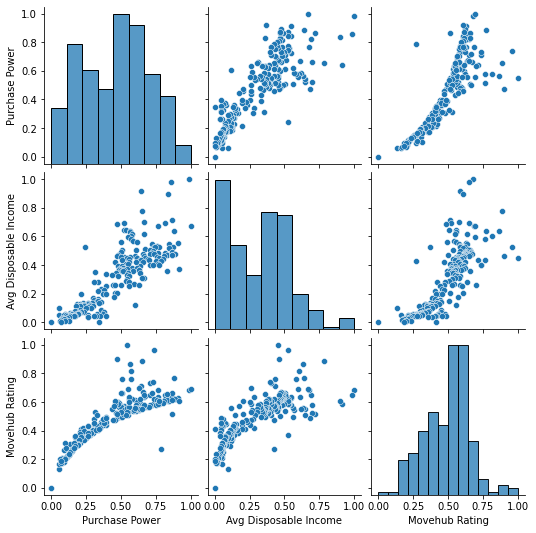

In [22]:
sns.pairplot(movehub_data[['Purchase Power', 'Avg Disposable Income', 
                           'Movehub Rating']])

In [23]:
print('Spearman rank correlation co-efficient for the data:')
movehub_data[['Purchase Power', 'Avg Disposable Income', 
              'Movehub Rating']].corr(method='spearman')

Spearman rank correlation co-efficient for the data:


Purchase Power  Avg Disposable Income  Movehub Rating
Purchase Power               1.000000               0.849239        0.877565
Avg Disposable Income        0.849239               1.000000        0.822675
Movehub Rating               0.877565               0.822675        1.000000

###### Data Analysis 

Looking at the above plots and statistics then observe the following:

    * Non-linear trend between Movehub Rating and Purchase Power
    * Non-linear trend between Movehub Rating and Avg Disposable Income 
    * Looks like there is correlation between Purchase Power and Avg Disposable Income 
    * Movehub Rating looks like a skewed Normal distribution
    
 Reference for distributions - https://github.com/rasmusab/distribution_diagrams

##### Model 1 - Step 2: Implement the bayesian model outlined below 

I am implementing the following model as from visually checking the data there appears to be a non-linear trend between the 2 features and movehub rating.  There also appears to be a correlation between the 2 features themselves so I think this interaction model would be a good fit to the data.

Linear Model: $$ y = \alpha + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2 + \beta_4 x_1^2 + \beta_5 x_2^2 $$

Model: Linear Model + $\epsilon$ 

where $\epsilon$ is the error term and can be represented by $\epsilon \sim \mathcal{N}(0, \sigma^2)$

Choice of likelihood:  Normal distribution 

    Reason: Due to the error term in the equation above then each prediction made by our model is coming from a 
    probability density function (pdf).  This pdf will be a normal distrubution with a mean due to the linear model 
    and a variance equal to the difference between actual values and predicted linear trend values.

Choice of priors: 

- Normal distribution for y-intercept & co-efficients 
- HalfNormal distribution for the error term ($\sigma^2$) as it's a squared term so can't be negative
    
        Reason: Movehub Rating is a ranking for cities that is assigned based on features that quantify the 
        quality of life and cost of living.  A lot of cities will have similar qualities and so most cities 
        will likely have a similar ranked value and be close together.  There will be a small sample of cities 
        that perform exceptionally well and rank really high and then some that aren't so good.  Based on this 
        prior belief then a normal distribution makes the most sense as we are likely to see cities clustered 
        close together around a mean rating with some variance in the data for the small numbers of very high 
        or very low ranked cities.

In [24]:
def get_train_test_data_model1(movehub_data):
    """
        movehub_data: pandas dataframe containing the normalised movehub dataset
        
        return: training and test datasets 
    """
    ## Setup the feature data for the linear interaction model described above
    X_model1 = movehub_data[['Purchase Power', 'Avg Disposable Income']]
    X_model1['x1x2'] = X_model1['Purchase Power'] * X_model1['Avg Disposable Income']
    X_model1['x12'] = X_model1['Purchase Power'] * X_model1['Purchase Power']
    X_model1['x22'] = X_model1['Avg Disposable Income'] * X_model1['Avg Disposable Income']

    ## Setup the response variable 
    y = movehub_data['Movehub Rating']

    ## Create train test split
    X_train, X_test, y_train, y_test = train_test_split(X_model1, y, 
                                                        test_size=0.3, 
                                                        random_state=42)
    return X_train, X_test, y_train, y_test

def build_model(X_train, y_train):
    """
        X_train: training data for the features 
        y_train: response variable training data 
        
        return trace_model1: the bayesian model
    """
    with pm.Model() as movehub_model1:
        α = pm.Normal('α', mu=0, sd=1) # Y intercept
        β = pm.Normal('β', mu=0, sd=1, shape=5) # Co-efficients
        ϵ = pm.HalfNormal('ϵ', 1) 

        μ = α + pm.math.dot(X_train, β)

        y_pred_model1 = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_train)

        trace_model1 = pm.sample(2000) 
        return trace_model1


def evaluate_model1(model1, X_test, y_test):
    """
        model1: the bayesian model 
        X_test: the test data features
        y_test: the test data response
        
        return: mse_model1 which is the mean sqaured error score for 
        this model
    """
    α_model1 = model1['α'].mean()
    β_model1 = model1['β'].mean(axis=0)
    y_pred_model1 = α_model1 + np.dot(X_test, β_model1)
    mse_model1 = mean_squared_error(y_test, y_pred_model1)
    return mse_model1


def build_and_evaluate_model1(data):
    """
        data: pandas dataframe containing the dataset
        
        return: model1 - the model object 
                mse_model1 - the mse score for this model
    """
    X_train_m1, X_test_m1, y_train_m1, y_test_m1 = get_train_test_data_model1(data)
    model1 = build_model(X_train_m1, y_train_m1)
    mse_model1 = evaluate_model1(model1, X_test_m1, y_test_m1)
    print('Mean squared error for model1 is: ', mse_model1)
    return model1, mse_model1
    
    

In [25]:
model1, mse_score_model1 = build_and_evaluate_model1(movehub_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Mean squared error for model1 is:  0.007011319456309111


#### Bayesian Model 2 

This bayesian model investigates the ability of the following features to predict 'Movehub Rating'

    * Purchase Power
    * Health Care
    * Pollution
    * Quality of Life
    * Crime Rating
    
##### Model 2 - Step 1: Explore this data to help determine the linear model, likelihood and priors to use

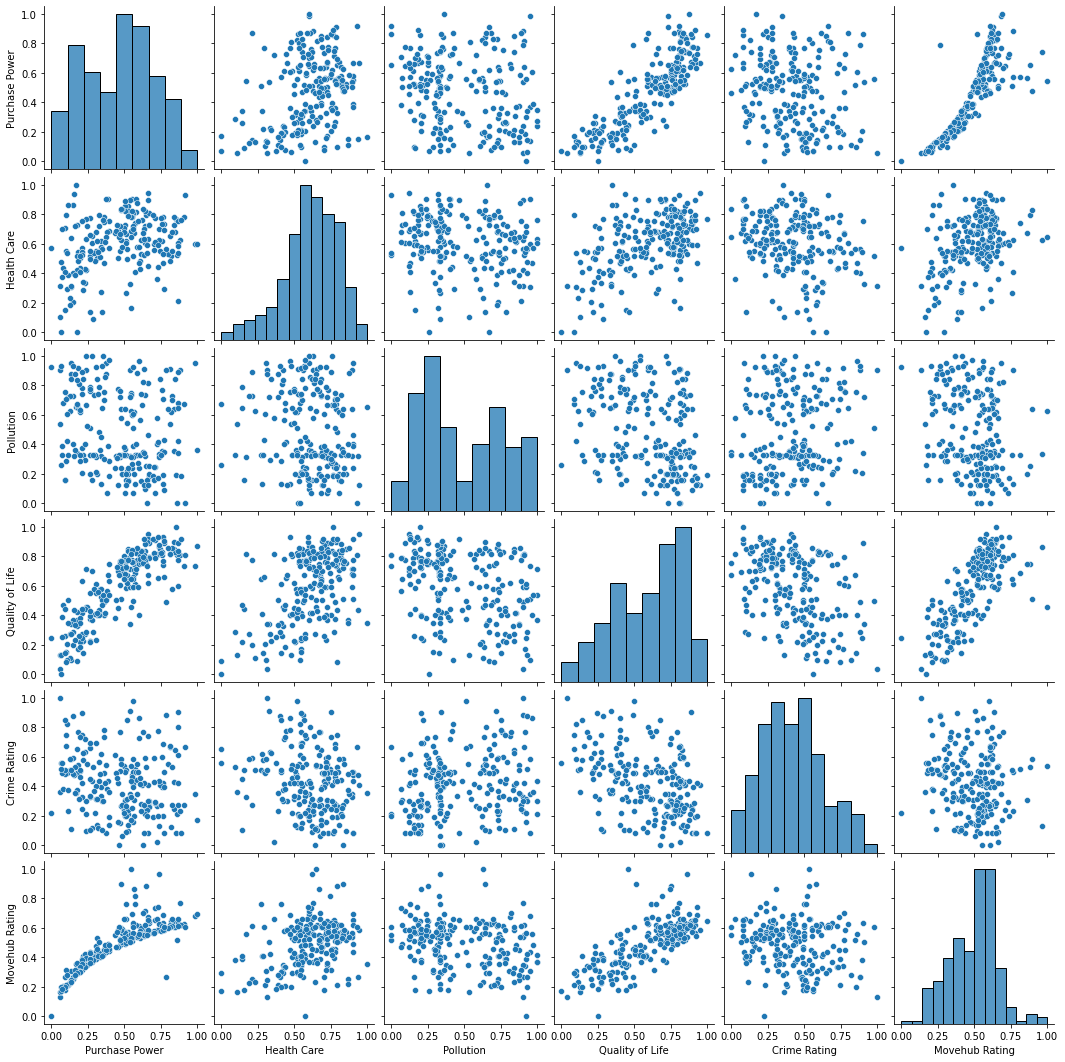

In [26]:
sns.pairplot(movehub_data[['Purchase Power', 'Health Care', 'Pollution', 
                           'Quality of Life','Crime Rating', 
                           'Movehub Rating']])

###### Data Analysis 

Looking at the above plots the following can be observed:

    * Non-linear trend between Movehub Rating and Purchase Power
    * Linear trend between Movehub Rating and Quality of Life 

##### Model 2 - Step 2: Implement the bayesian model outlined below 

I am implementing the following model where purchase power will be represented by x_1 and will be a 2nd order polynomial due to the non-linear trend it appears to have with Movehub Rating. 

Linear Model: $$ y = \alpha + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5 + \beta_6 x_1^2$$

Model = Linear Model + $\epsilon$

where $\epsilon$ is the error term

Choice of likelihood:  Normal distribution 

    Reason: Due to the error term in the equation above then each prediction made by our model is coming 
    from a probability density function (pdf).  This pdf will be a normal distrubution with a mean due to the 
    linear model and a variance equal to the difference between actual values and predicted linear trend values.

Choice of priors: 

- Normal for y-intercept & co-efficients as looking at it is most likely that movehub ratings are centered around a mean value with some variance in the data as most cities are generally fairly similar with a bit of variance.
- HalfNormal for the error term $\sigma^2$ as it's a squared term so can't be negative

In [27]:
def get_train_test_data_model2(movehub_data):
    """
        movehub_data: pandas dataframe containing the normalised 
                        movehub dataset
        
        return: training and test datasets 
    """
    ## Setup the feature data
    X_model2 = movehub_data[['Purchase Power', 'Health Care', 'Pollution', 
                             'Quality of Life', 'Crime Rating']]
    ## Create x1^2 feature
    X_model2['x12'] = X_model2['Purchase Power'] * X_model2['Purchase Power']

    ## Setup the response variable 
    y = movehub_data['Movehub Rating']

    ## Create train test split
    X_train, X_test, y_train, y_test = train_test_split(X_model2, y, 
                                                        test_size=0.3, 
                                                        random_state=42)
    return X_train, X_test, y_train, y_test
    
def build_model2(X_train, y_train):
    """
        X_train: training data for the features 
        y_train: response variable training data 
        
        return trace_model1: the bayesian model
    """
    with pm.Model() as movehub_model2:
        α = pm.Normal('α', mu=0, sd=1) # Y intercept
        β = pm.Normal('β', mu=0, sd=1, shape=6) # Co-efficients
        ϵ = pm.HalfNormal('ϵ', 1) 

        μ = α + pm.math.dot(X_train, β)

        y_pred_model2 = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_train)

        trace_model2 = pm.sample(2000) 
        return trace_model2
        
def evaluate_model2(model2, X_test, y_test):
    """
        model2: the bayesian model 
        X_test: the test data features
        y_test: the test data response
        
        return: mse_model2 which is the mean sqaured error score for this model
    """
    α_model2 = model2['α'].mean()
    β_model2 = model2['β'].mean(axis=0)
    y_pred_model2 = α_model2 + np.dot(X_test, β_model2)
    mse_model2 = mean_squared_error(y_test, y_pred_model2)
    return mse_model2
    
    
def build_and_evaluate_model2(data):
    """
        data: pandas dataframe containing the dataset
        
        return: model1 - the model object 
                mse_model1 - the mse score for this model
    """
    X_train_m2, X_test_m2, y_train_m2, y_test_m2 = get_train_test_data_model2(data)
    model2 = build_model2(X_train_m2, y_train_m2)
    mse_model2 = evaluate_model2(model2, X_test_m2, y_test_m2)
    print('Mean squared error for model2 is: ', mse_model2)
    return model2, mse_model2
    
    

In [28]:
model2, mse_score_model2 = build_and_evaluate_model2(movehub_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Mean squared error for model2 is:  0.007274083485503916


#### Bayesian Model 3 

This bayesian model investigates the ability of all 11 features to predict 'Movehub Rating'

##### Model 3 - Step 1: Explore this data to help determine the linear model, likelihood and priors to use

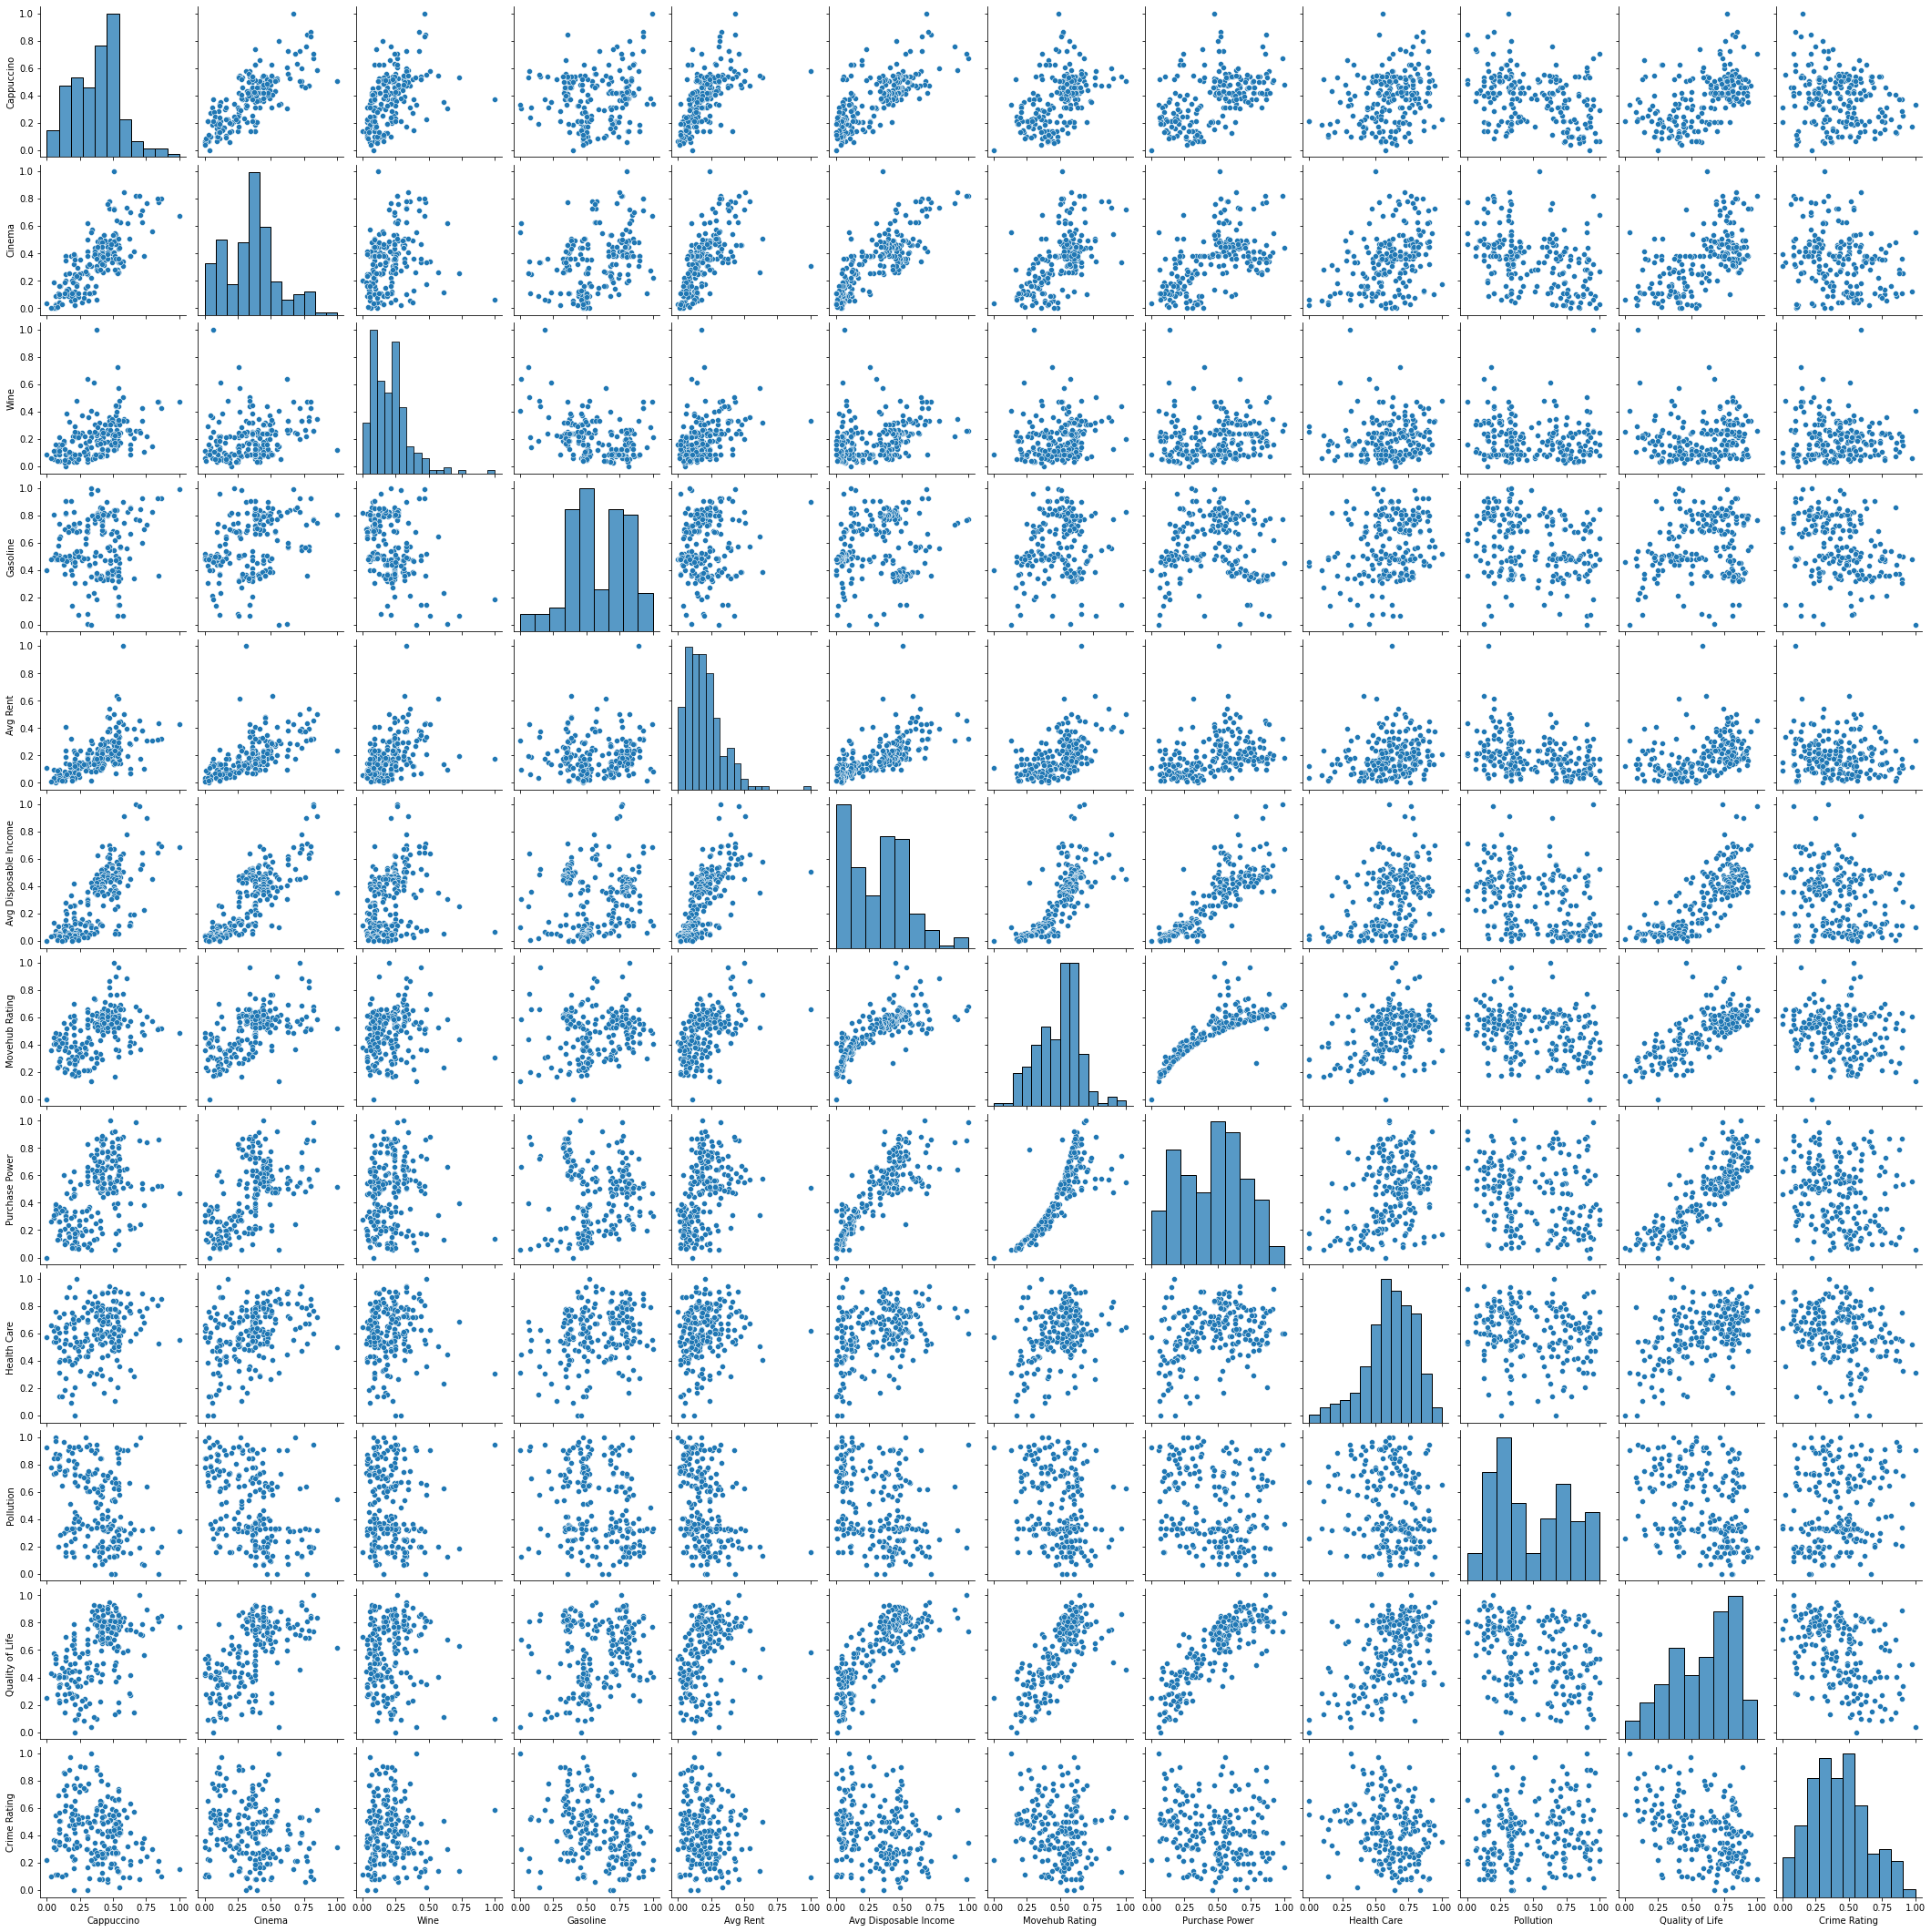

In [29]:
sns.pairplot(movehub_data)

###### Data Analysis 

Looking at the above plots and statistics then observe the following:

    * Non-linear trend between Movehub Rating and Purchase Power
    * Non-linear trend between Movehub Rating and Avg Disposable Income
    * Movehub Rating looks like a skewed Normal distribution
    

##### Model 3 - Step 2: Implement the bayesian model outlined below 

I am implementing the following model where 

Purchase Power and Avg Disposable Income will be 2nd order polynomials due to the non-linear trend they appear to have with Movehub Rating. 

Linear Model: $$ y = \alpha + \beta x$$

Model = Linear Model + $\epsilon$

where $\epsilon$ is the error term

Choice of likelihood:  Normal distribution 

    Reason: Due to the error term in the equation above then each prediction made by our model is coming 
    from a probability density function (pdf).  This pdf will be a normal distrubution with a mean due to the 
    linear model and a variance equal to the difference between actual values and predicted linear trend values.

Choice of priors: 

- Normal for y-intercept & co-efficients as looking at it is most likely that movehub ratings are centered around a mean value with some variance in the data as most cities are generally fairly similar with a bit of variance.
- HalfNormal for the error term $\sigma^2$ as it's a squared term so can't be negative

In [30]:
def get_train_test_data_model3(movehub_data):
    """
        movehub_data: pandas dataframe containing the normalised 
                        movehub dataset
        
        return: training and test datasets 
    """
    ## Setup the feature data
    X_model3 = movehub_data.drop(columns=['Movehub Rating'], inplace=False)
    X_model3['x12'] = X_model3['Purchase Power'] * X_model3['Purchase Power']
    X_model3['x22'] = X_model3['Avg Disposable Income'] * X_model3['Avg Disposable Income']

    ## Setup the response variable 
    y = movehub_data['Movehub Rating']

    ## Create train test split
    X_train, X_test, y_train, y_test = train_test_split(X_model3, y, 
                                                        test_size=0.3, 
                                                        random_state=42)

    return X_train, X_test, y_train, y_test
    
def build_model3(X_train, y_train):
    """
        X_train: training data for the features 
        y_train: response variable training data 
        
        return trace_model3: the bayesian model
    """
    with pm.Model() as movehub_model2:
        α = pm.Normal('α', mu=0, sd=1) # Y intercept
        β = pm.Normal('β', mu=0, sd=1, shape=13) # Co-efficients
        ϵ = pm.HalfNormal('ϵ', 1) 

        μ = α + pm.math.dot(X_train, β)

        y_pred_model3 = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_train)

        trace_model3 = pm.sample(2000) 
        return trace_model3
        
def evaluate_model3(model3, X_test, y_test):
    """
        model3: the bayesian model 
        X_test: the test data features
        y_test: the test data response
        
        return: mse_model3 which is the mean sqaured error 
                    score for this model
    """
    α_model3 = model3['α'].mean()
    β_model3 = model3['β'].mean(axis=0)
    y_pred_model3 = α_model3 + np.dot(X_test, β_model3)
    mse_model3 = mean_squared_error(y_test, y_pred_model3)
    return mse_model3
    
    
def build_and_evaluate_model3(data):
    """
        data: pandas dataframe containing the dataset
        
        return: model1 - the model object 
                mse_model1 - the mse score for this model
    """
    X_train_m3, X_test_m3, y_train_m3, y_test_m3 = get_train_test_data_model3(data)
    model3 = build_model3(X_train_m3, y_train_m3)
    mse_model3 = evaluate_model3(model3, X_test_m3, y_test_m3)
    print('Mean squared error for model3 is: ', mse_model3)
    return model3, mse_model3
    
    

In [31]:
model3, mse_score_model3 = build_and_evaluate_model3(movehub_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Mean squared error for model3 is:  0.0064971079882042634


### Model Analysis 

The following cells evaulate the 3 Bayesian linear regression models built to assess the impact of different features on the 'Movehub Rating' score.

#### Step 1 - Visual Inspection of the trajectory for each model

The trace plot is a good visual examination of whether we have got a good match for the posterior using MCMC.  If the trace plot looks like a mess (often described as a hairy caterpillar) then that is an indicator there is a lot of movement in the chain and a variety of values are being sampled.  This is good as the values in the chain must be representative of the posterior distribution and so the range of the posterior needs to be fully explored.

The density plots of the posterior should overlap well if MCMC has converged successfully. 

Model 1 - Trace Plot


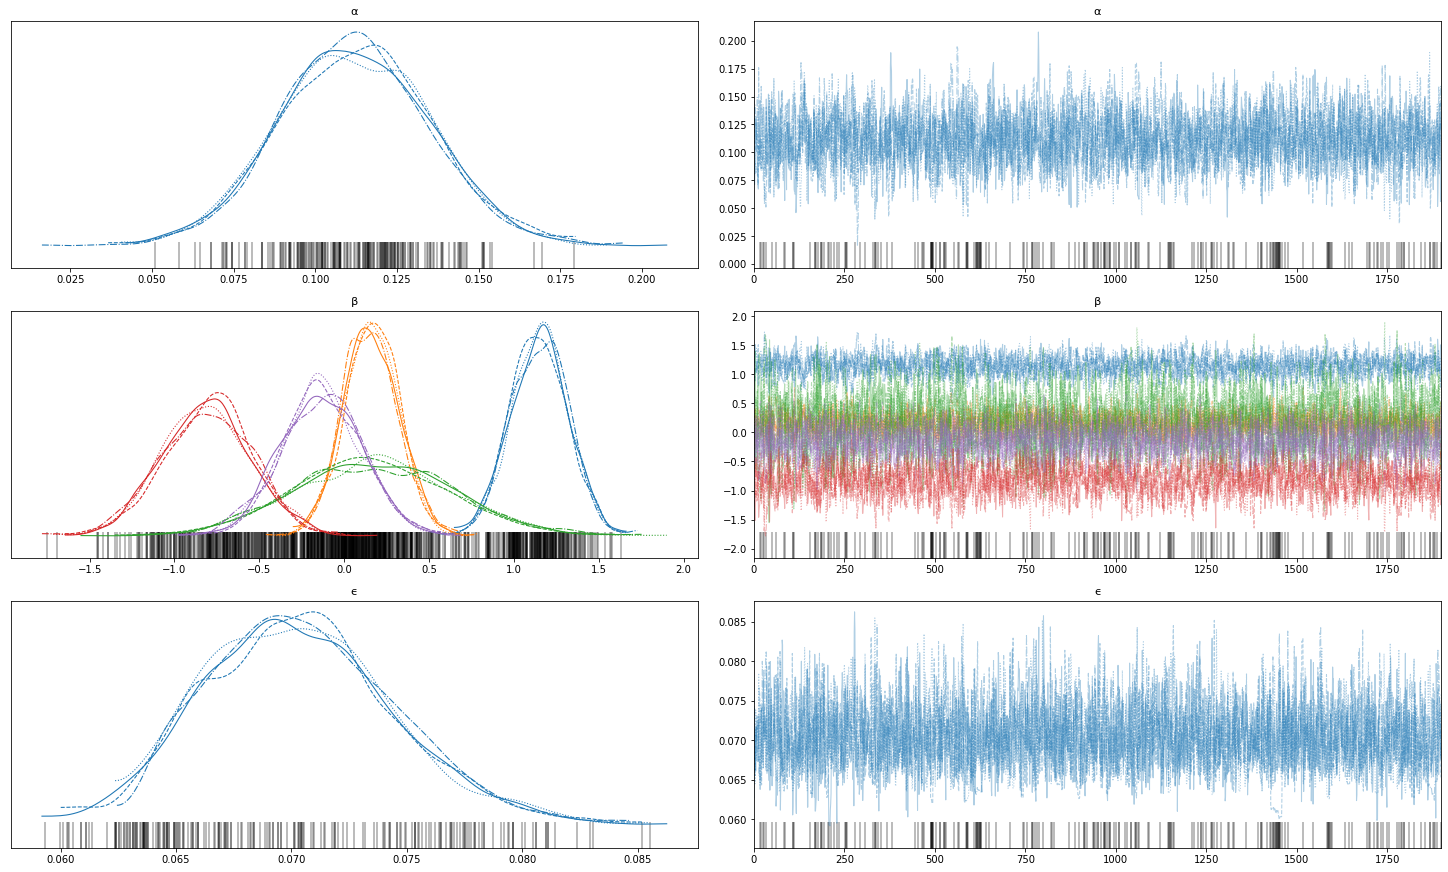

In [32]:
print('Model 1 - Trace Plot')
burnin = 100
multi_chain_model1 = model1[burnin:]
ax = pm.traceplot(multi_chain_model1,figsize=(20,12))

Model 2 - Trace Plot


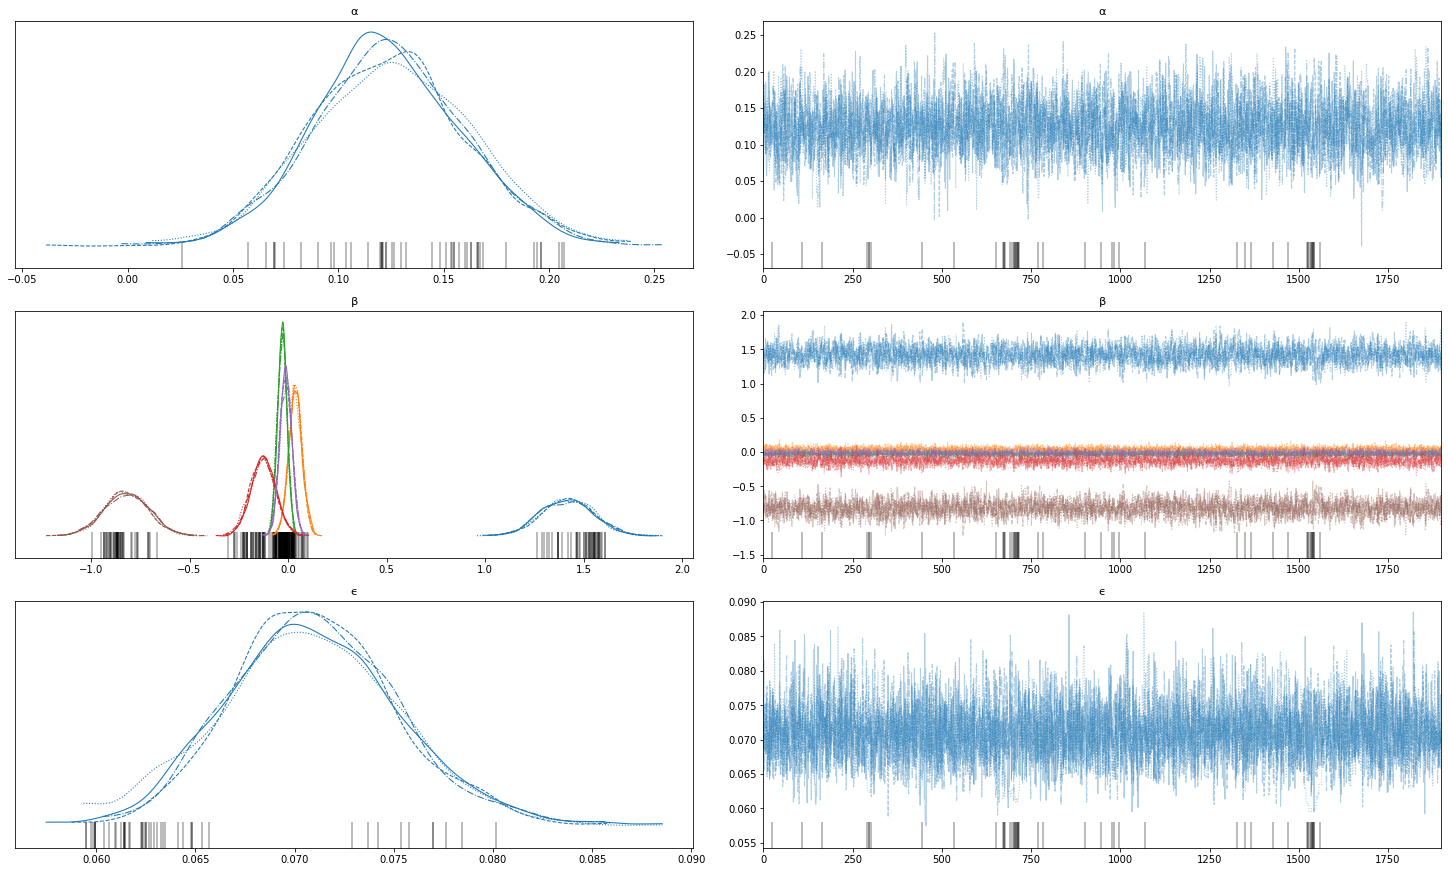

In [33]:
print('Model 2 - Trace Plot')
burnin = 100
multi_chain_model2 = model2[burnin:]
ax2 = pm.traceplot(multi_chain_model2,figsize=(20,12))

Model 3 - Trace Plot


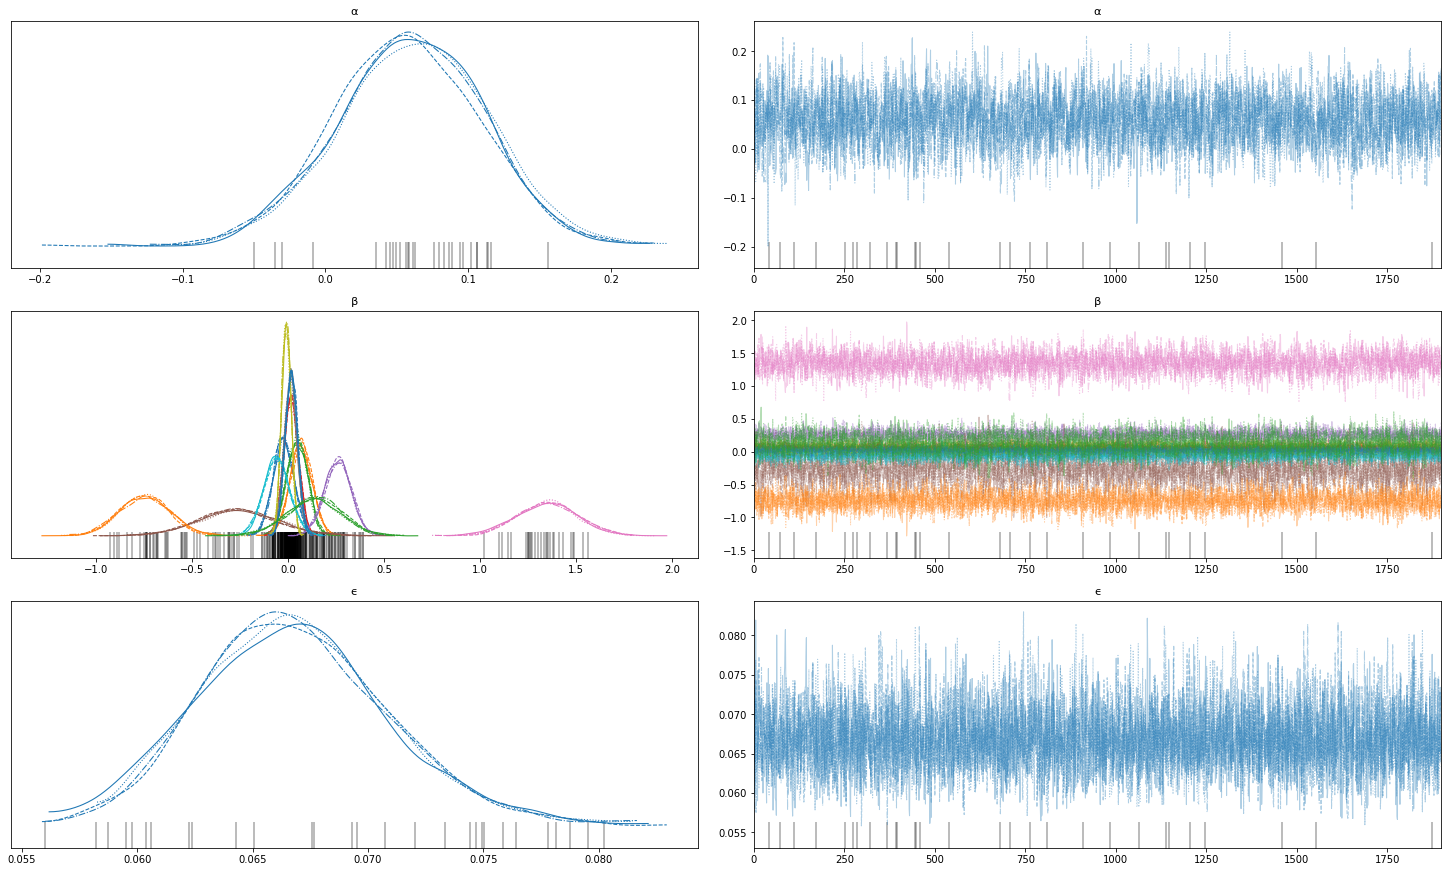

In [34]:
print('Model 3 - Trace Plot')
burnin = 100
multi_chain_model3 = model3[burnin:]
ax3 = pm.traceplot(multi_chain_model3,figsize=(20,12))

#### Analysis - Visual inspection of the trajectory

We can see from the plots above that for all 3 models the density plots do appear to overlap and the trace plot looks like a hairy caterpillar so this does indicate that we have a good match for the posterior distribution.



#### Step 2- Numerical mesaure of convergence for each model

The Gelman-Rubin statistic (R_hat) compares the variance within chains to the variance between chains.  If all chains have settled into a representative sampling, then the average difference between the chains should be the same as the average difference (across steps) within the chains.  So, the ideal R_hat is 1.

In [35]:
print('Model 1 Summary')
print(pm.summary(multi_chain_model1))

print('\n\n\n')
print('Model 2 Summary')
print(pm.summary(multi_chain_model2))


print('\n\n\n')
print('Model 3 Summary')
print(pm.summary(multi_chain_model3))

Model 1 Summary
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
α     0.112  0.023   0.069    0.155      0.000    0.000    2474.0  2424.0   
β[0]  1.150  0.169   0.842    1.473      0.004    0.003    1815.0  1815.0   
β[1]  0.160  0.161  -0.140    0.466      0.004    0.002    2108.0  2108.0   
β[2]  0.170  0.466  -0.708    1.029      0.011    0.008    1776.0  1776.0   
β[3] -0.811  0.262  -1.317   -0.331      0.007    0.005    1584.0  1584.0   
β[4] -0.133  0.239  -0.595    0.303      0.005    0.004    2370.0  2325.0   
ϵ     0.070  0.004   0.063    0.078      0.000    0.000    2347.0  2347.0   

      ess_bulk  ess_tail  r_hat  
α       2479.0    2858.0    1.0  
β[0]    1817.0    2216.0    1.0  
β[1]    2110.0    3058.0    1.0  
β[2]    1779.0    2530.0    1.0  
β[3]    1585.0    2543.0    1.0  
β[4]    2377.0    2808.0    1.0  
ϵ       2012.0    1104.0    1.0  




Model 2 Summary
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  

#### Analysis - Numerical measure of convergence 

The summary information above shows the R_hat is 1 for all models which again provides support that the MCMC chains did converge for all 3 models.

#### Step3 - Model Evaluation

A test data set was held out from model building so that it could be used to evaluate the performance of the model.  For each of the 3 MCMC models the mean squared error (MSE) performance metric was calculated and is shown below.  The lower the MSE then the smaller the difference between the predicted values and the actual values and so the better the model appears to be performing.  

In [36]:
print('Model 1 MSE metric: ', mse_score_model1)
print('\n\n')
print('Model 2 MSE metric: ', mse_score_model2)
print('\n\n')
print('Model 3 MSE metric: ', mse_score_model3)

Model 1 MSE metric:  0.007011319456309111



Model 2 MSE metric:  0.007274083485503916



Model 3 MSE metric:  0.0064971079882042634


#### Analysis - Model Evaluation

From the MSE scores above then it appears that model 3 was the best performing.

### Conclusions 

Overall the 3 MCMC models that were built appeared to converge from the visual inspection of the traceplots and from the Gelman-Rubin statistics.  The optimal model based on the mean squared error metric appears to be model 3 which made use of all the features and not a subset like model 1 and model 2.  

## Part 3 - Unsupervised Learning 

Data Set: leukaemia_samples dataset

Goal: Apply clustering techniques to the leukaemia dataset to determine impact of linkage measues, calculate the ideal number of clusters and finally compare the performance of hierarchical and K-means clustering for the ideal clusters.

### Exploratory Data Analysis 

In this section the data is analysed to better understand if there is any missing data as well as the distributions of the features before applying the clustering techniques.  

In [37]:
#Libraries required to answer this question
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score 
from sklearn.metrics import davies_bouldin_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [38]:
orig_data = pd.read_csv('Data/leukaemia_samples.csv')
orig_data.head()

38 Class  U22376  X59417  U05259  M92287  M31211  X74262  D26156  \
0  sample_12   ALL     551     846    2504    2056     334     209     329   
1  sample_25   ALL    1872    3878    5070    1689     481     489     738   
2  sample_34   AML    1126     782     711     498     153     279     302   
3  sample_35   AML     880     490     654     165      19     336     201   
4  sample_36   AML     473    1648     -14    1309      88     194     667   

   S50223  ...  M62762  M28130  M63138  M57710  M69043  M81695  X85116  \
0      90  ...    1030    1855    1763     988    7901     494     530   
1     301  ...     933    4271    1371     560   14011     439     559   
2      56  ...    3236    3693    5587     394   13338    1702     727   
3     168  ...    1125     -45    3909      72    2306    1137    1639   
4     -73  ...    4647   11517   12358    5940   21135    2014    1096   

   M19045  M83652  X04085  
0    3939     252     294  
1     515     -49     747  
2    4259    1338    5878  
3    2517     565    2140  
4   15519    2892    5162  

[5 rows x 52 columns]

In [39]:
print('Columns that have null data:')
print(orig_data.columns[orig_data.isna().any()].tolist())

Columns that have null data:
[]


In [40]:
print(orig_data.describe(include='all'))

               38 Class       U22376       X59417       U05259        M92287  \
count          38    38    38.000000    38.000000    38.000000     38.000000   
unique         38     2          NaN          NaN          NaN           NaN   
top     sample_26   ALL          NaN          NaN          NaN           NaN   
freq            1    27          NaN          NaN          NaN           NaN   
mean          NaN   NaN  2948.289474  3428.342105  2614.973684   3173.842105   
std           NaN   NaN  2226.180208  2443.969592  2739.455050   2407.634451   
min           NaN   NaN   186.000000    99.000000   -14.000000    165.000000   
25%           NaN   NaN  1064.750000  1566.500000   288.000000   1358.000000   
50%           NaN   NaN  2981.000000  2735.500000   882.500000   2628.500000   
75%           NaN   NaN  4488.750000  5450.000000  5073.750000   4064.250000   
max           NaN   NaN  9177.000000  7782.000000  9326.000000  10669.000000   

             M31211       X74262       

#### Initial Analysis 

Column 38 in the dataframe refers to the sample numnber and Class column refers to the type of leukaemia i.e. AML refers to acute myeloid leukaemia and ALL refers to acute lymphoblastic leukaemia.

These columns will need to be removed from the cluster analysis as class is the response variable and we don't need a unique ID column as we have the dataframe index.

There is no null data in this dataset so we don't need to worry about missing data.

The description statistics on the other 50 numerical columns show there is a range in the magnitude of the data measures.  For example column S50223 values range between -94 and 867 whereas M19045 values range from 71 to 15519.  It would therefore be better to normalise the data so that every variable is on the same scale.

In the next cells I will implement the pre-processing functions to drop the 2 columns we don't need as well as normalize the data prior to applying clustering techniques.

### Preprocessing functions

In the next cells I define preprocessing functions to get the data ready for clustering.

The preprocessing steps are:

    1) Read in data and drop the 2 unnecessary columns 38 and Class that refer to the unique data ID and a cluster label
    
    2) Normalize the data using MinMaxScalar 

In [41]:
def get_data():
    """ 
        return: pandas dataframe containing the normalised dataset 
                with cluster label and unique ID columns removed
    """
    orig_data = pd.read_csv('Data/leukaemia_samples.csv')
    ## Remove the unique ID and cluster label columns
    cluster_data = orig_data.drop(columns=['38', 'Class'])
    
    ## Normalise the feature variables 
    normalise_transformer = ColumnTransformer([('normalise', 
                                                MinMaxScaler(),
                                                make_column_selector(
                                                    dtype_include=np.number))])
    normalised_df = pd.DataFrame(normalise_transformer.fit_transform(cluster_data),
                                 index=cluster_data.index, 
                                 columns = cluster_data.columns)
    return normalised_df

### Agglomerative Clustering 

Use Agglomerative Clustering on the dataset to obtain 2, 3 and 4 clusters and plot the dendrogram.

In [42]:
def plot_dendrogram(data, linkage_value):
    """
        data: Pandas dataframe containing the feature data 
        linkage_value: String containing linkage method 
                        to be used e.g. "ward" or "average"
        
        Plot a basic dendrogram 
    """
    linked = linkage(data, linkage_value) 
    plt.figure(figsize=(10, 7))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Data index')
    plt.ylabel('Distance')
    dendrogram(linked, orientation='top', 
               distance_sort='descending', show_leaf_counts=True)
    plt.show()


def plot_truncated_dendrogram(data, linkage_value):
    """
        data: Pandas dataframe containing the feature data 
        linkage_value: String containing linkage method to be used 
                        e.g. "ward" or "average"
        
        Plot a truncated dendrogram 
    """
    linked = linkage(data, linkage_value) 
    plt.figure(figsize=(10, 7))
    plt.title('Hierarchical Clustering Dendrogram (truncated)')
    plt.xlabel('Data index or (cluster size)')
    plt.ylabel('Distance')
    dendrogram(linked, 
               truncate_mode='lastp',  # show the last p merged clusters
               p=5,  # show only the last p merged cluster
               show_leaf_counts=True,  # numbers in brackets are counts
               leaf_rotation=90.,
               leaf_font_size=12.,
               show_contracted=True)
    plt.show()


def plot_truncated_dendrogram_with_cut_off(data, linkage_value, cut_off):
    """
        data: Pandas dataframe containing the feature data 
        linkage_value: String containing linkage method to be used 
                        e.g. "ward" or "average"
        cut_off: Number that represents max distance for cutting 
                    the clusters
        
        Plot a truncated dendrogram with a distance cut off line 
            plotted on top of the tree
    """
    linked = linkage(data, linkage_value) 
    plt.figure(figsize=(10, 7))
    plt.title('Hierarchical Clustering Dendrogram (truncated) With Cut Off')
    plt.xlabel('Data index or (cluster size)')
    plt.ylabel('Distance')
    dendoplt = dendrogram(linked, 
                       truncate_mode='lastp',  # show only the last p merged clusters
                       p=5,  # show only the last p merged cluster
                       show_leaf_counts=True,  # otherwise numbers in brackets are counts
                       leaf_rotation=90.,
                       leaf_font_size=12.,
                       show_contracted=True)
    plt.axhline(y=cut_off, c='k')
    plt.show()

def plot_multi_cluster_distribution(cluster1, cluster2, cluster3):
    """
        cluster1: Pandas dataframe containing the clustered data 
        cluster2: Pandas dataframe containing the clustered data
        cluster3: Pandas dataframe containing the clustered data
    """
    fig, ax =plt.subplots(1,3,figsize=(12,6))
    fig.suptitle('Histogram for cluster distributions')
    sns.histplot(data=cluster1, x="Cluster_Label", discrete=True, ax=ax[0])
    sns.histplot(data=cluster2, x="Cluster_Label", discrete=True, ax=ax[1])
    sns.histplot(data=cluster3, x="Cluster_Label", discrete=True, ax=ax[2])
    ax[0].set_title('2 Clusters')
    ax[1].set_title('3 Clusters')
    ax[2].set_title('4 Clusters')
    fig.show()

def create_cluster(data, num_clusters, affinity_measure, linkage_measure):
    """
        data: Pandas dataframe containing the data features 
        num_clusters: Integer containing the number of clusters to use
        affinity_measure: String containing the affinity measure to use 
        linkage_measure: String containing the linkage measure to use
    """
    cluster = AgglomerativeClustering(n_clusters=num_clusters, 
                                      affinity=affinity_measure, 
                                      linkage=linkage_measure) 
    cluster.fit_predict(data)
    data['Cluster_Label'] = cluster.labels_
    return data

def create_and_display_dengrograms_and_cluster_distribtions():
    leukaemia_df = get_data()
    plot_dendrogram(leukaemia_df, 'ward')
    plot_truncated_dendrogram(leukaemia_df, 'ward')

    affinity_measure = 'euclidean'
    linkage_measure = 'ward'
    cluster2 = create_cluster(get_data(), 2, affinity_measure, linkage_measure)
    cluster3 = create_cluster(get_data(), 3, affinity_measure, linkage_measure)
    cluster4 = create_cluster(get_data(), 4, affinity_measure, linkage_measure)
    plot_multi_cluster_distribution(cluster2, cluster3, cluster4)
    

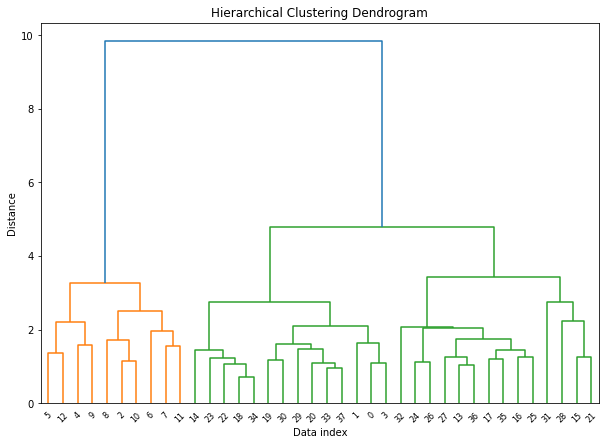

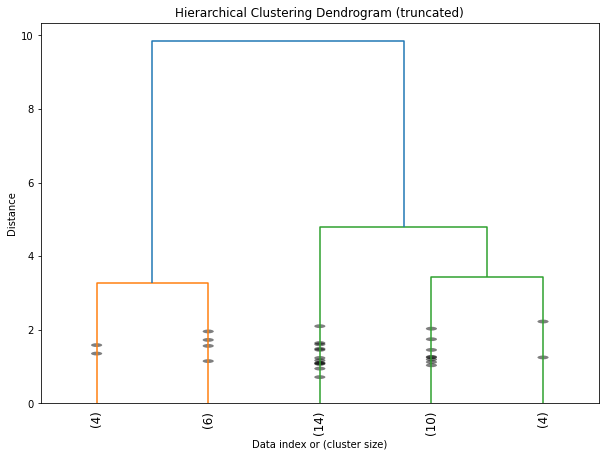

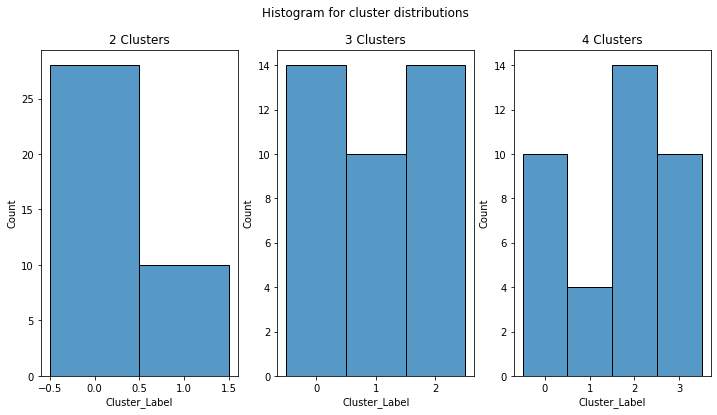

In [43]:
create_and_display_dengrograms_and_cluster_distribtions()

#### Analysis

There are two dendrogram plots above with the first one showing all the nodes while the second shows a truncated dendogram.  The truncated dendrogram highlights the cluster sizes and where the large groupings are.

The bottom plot shows the distribution of points belonging to the different clusters. 

When there are only 2 clusters then it looks like the data is split with cluster 1 consisting of the orange branches from the dendrogram while cluster 0 consisting of the green branches in the dendrogram.  

When there are 3 clusters then it looks like the data in the green branch of the dendrogram is split to form clusters 0 and 2 while the data in the orange branch appears to remain in a single cluster.  

When there are 4 clusters then it looks like a similar pattern occurs where the data in the green branch of the dendrogram is split to form clusters 1, 2 and 3 while the data in the orange branch continues to remain in a single cluster. 

This makes sense as AgglomerativeClustering will use a max distance cut off to determine the number of clusters and if I plot the dendrogram with a distance cut off below then you can see how it forms the 4 clusters.

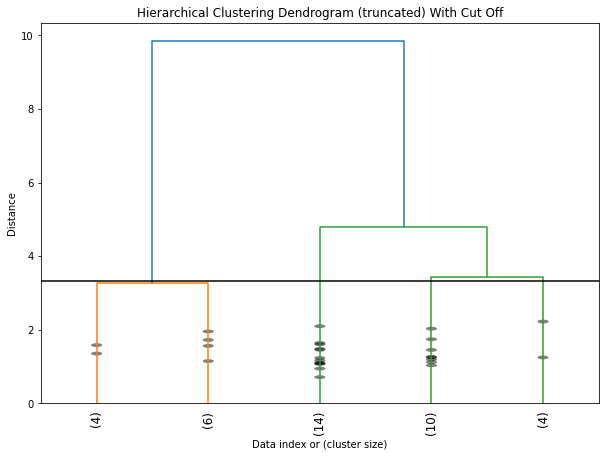

In [44]:
plot_truncated_dendrogram_with_cut_off(get_data(), 'ward', 3.32)

### Agglomerative Clustering - Linkage Analysis

Setting the number of clusters to 3 then I will assess the impact of the different linkage methods on the cluster results.

In [45]:
def plot_model_dendogram_and_cluster_distribution(data, linkage_value):
    """
        data: Pandas dataframe containing the dataset
        linkage_value: String containing linkage e.g. 'ward'
    """
    linked = linkage(data, linkage_value) 
    fig, ax =plt.subplots(1,2,figsize=(15,7))
    fig.suptitle('Results for linkage ' + str(linkage_value))
    dendrogram(linked, orientation='top', distance_sort='descending', 
               show_leaf_counts=True, ax=ax[0])
    sns.histplot(data=data, x="Cluster_Label", discrete=True, ax=ax[1])
    ax[0].set_title('Dendogram')
    ax[1].set_title('Cluster Distribution')
    fig.show()

def create_and_plot_linkage_effect(data):
    """
        data: Pandas dataframe containing the dataset 
        
        return: data which is Pandas dataframe with original 
                    data and cluster results
    """
    affinity_measure = 'euclidean'
    linkage_values = ['ward', 'complete', 'average', 'single']
    for linkage_value in linkage_values:
        clustered_data = create_cluster(data, 3, affinity_measure, 
                                        linkage_value) 
        data[linkage_value] = clustered_data["Cluster_Label"]
        plot_title = 'Results for linkage ' + str(linkage_value) 
        plot_model_dendogram_and_cluster_distribution(clustered_data, 
                                                      linkage_value)
    return data

In [46]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

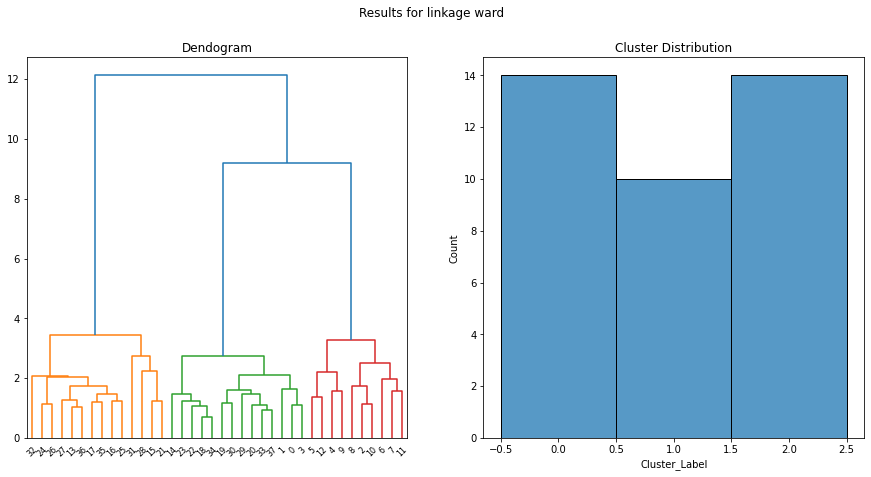

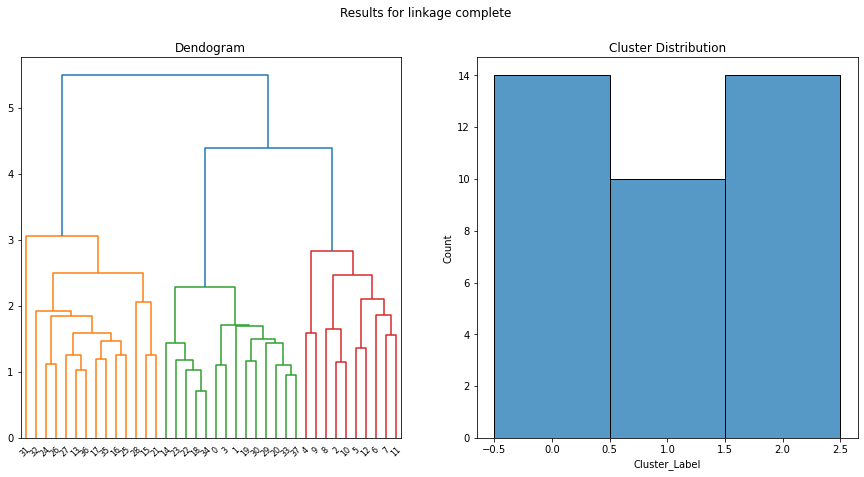

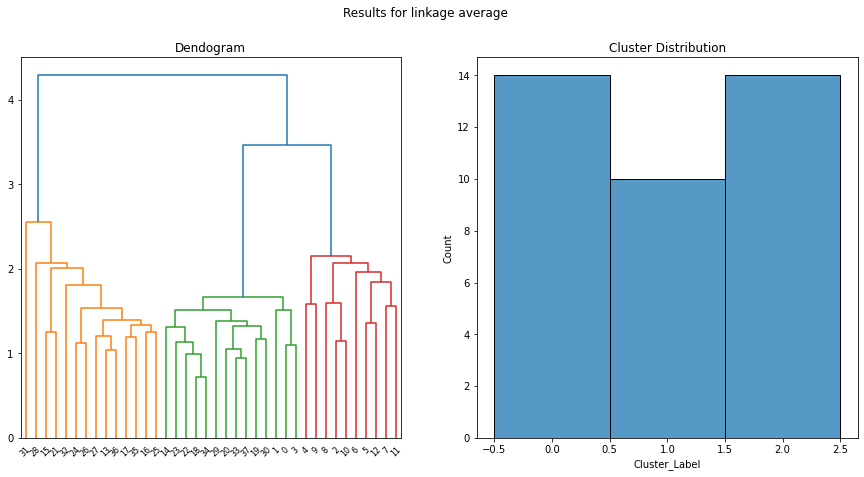

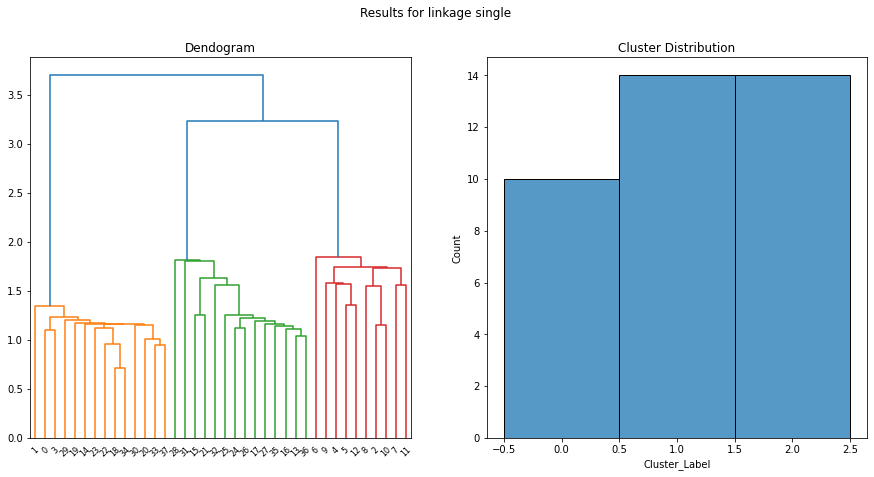

In [47]:
resulting_data = create_and_plot_linkage_effect(get_data())

In [48]:
resulting_data[['ward', 'complete', 
                'average', 'single']].sort_values(by=['ward']).head(40)

ward  complete  average  single
28     0         0        0       1
21     0         0        0       1
31     0         0        0       1
32     0         0        0       1
36     0         0        0       1
17     0         0        0       1
16     0         0        0       1
15     0         0        0       1
27     0         0        0       1
13     0         0        0       1
25     0         0        0       1
24     0         0        0       1
26     0         0        0       1
35     0         0        0       1
12     1         1        1       0
9      1         1        1       0
8      1         1        1       0
7      1         1        1       0
6      1         1        1       0
5      1         1        1       0
4      1         1        1       0
2      1         1        1       0
10     1         1        1       0
11     1         1        1       0
0      2         2        2       2
30     2         2        2       2
34     2         2        2       2
29     2         2        2       2
33     2         2        2       2
18     2         2        2       2
22     2         2        2       2
20     2         2        2       2
19     2         2        2       2
14     2         2        2       2
3      2         2        2       2
1      2         2        2       2
23     2         2        2       2
37     2         2        2       2

#### Analysis 

The above plots show the dendrograms and cluster distributions for the varying linkage methods.

The variations in the shape of the dendrograms and the distance measure on the Y-axis is a result of the linkage methods approach to measuring distances between clusters. 

Ward works to minimize the variance of the clusters being merged and so it will try and merge clusters that are closer and more densely packed. So when it merges the final clusters at the top of the tree to form the root node that consists of the entire dataset then this data will have a high spread in variance and hence the high distance value of 10.  The individual branches of the tree have a lot smaller distance values with the orange, red and green branchs all having a distance measure ~3 or less.  This shows that each of these clusters have a similar variance to each other and that this variance is a lot less than the entire dataset variance.   Due to 3 clusters being choosen for this partition then it looks like the red, orange and green branchs in the dendrogram make up the 3 clusters.  This can be clearly seen from the distribution of values within each cluster shown by the histogram for the ward linkage.

While complete looks at the farthest data points as it's distance measure, average linkage takes the average distance between the clusters and single measures the closest points between the clusters.  This difference in measurements for these 3 linkage methods is easily seen when looking at the distance values on the y-axis as single has the smallest distance values while complete has the largest distance value of these 3 methods.  

Looking at the indexes on the x-axis of the dendrogram you can see that how it builds up the clusters at the bottom of the tree is also different which is a result of the different measurement techniques.  For example for single linkage you can see that index 11 and 7 are joined together and then they are joined with a cluster consiting of 3 data indexes 10, 2 and 8.  Whereas for average linkage data indexes 11 and 7 are joined together before being joined with a cluster consisting of 2 data indexes 12 and 5.  

However, ultimately the final 3 clusters that are selected are actually the same between all 4 linkage methods.  This is highlighted in the table in the cell above which shows the cluster label for each data point for the different linkage methods.  The dendrograms for all 4 linkage methods clearly show 3 distinct branches with colours red, orange and green which relate to the 3 final clusters.  If we were to use a high number of clusters in the agglomerative clustering technique then we would see more variation in the data points being associated with each cluster due to the variance in how the orange, green and red branches are being formed. 




### Estimating Number of Cluster

In this section I will calculate validity indices to assess what the appropriate number of clusters would be iterating over different values for the cluster numbers, different distance metrics and algorithms.

I want to understand what the appropriate number of clusters are and whether there is an impact to this number based on distance metrics or algorithms used.

Validity indices I will use in this assessmet are:

* Davies-Bouldin index (DBI) which is related to intracluster distance (distance within the cluster) divided by intercluster distance (distance between clusters).  So the lower this value then the more separated and well defined the clusters are which is what we want.


* Mean Silhouette Coefficient (MSC) which is the mean silhouette score again based on intracluster and intercluster distance.  This coefficient has a range between -1 and 1 where -1 indicates misclassification, 0 indicates the clusters are not well defined and 1 indicates well defined, dense clusters.


* Calinski-Harabasz index (CHI) is based on the density and separation of the clusters with a higher CHI indicating clusters that are well defined and dense.

In [49]:
def calculating_validity_indices_hierarchical_clustering():
    """ 
        return: results_df which is a Pandas Dataframe 
                containing the results of the experiment
    """
    affinity_measures = ['euclidean', 'manhattan', 'cosine']
    linkage_values = ['complete', 'average', 'single']
    clusters = [2, 3, 4, 5, 6, 7, 8, 9]
    column_names = ['cluster_num', 'linkage','affinity','DBI','MSC','CHI']
    results_df = pd.DataFrame(columns=column_names)
    for cluster_num in clusters:
        for linkage_value in linkage_values:
            for affinity_measure in affinity_measures:
                clustered_data = create_cluster(get_data(), 
                                                cluster_num, 
                                                affinity_measure, 
                                                linkage_value) 
                X = clustered_data.drop(columns=['Cluster_Label'])
                labels = clustered_data["Cluster_Label"]
                dbi_score = davies_bouldin_score(X, labels)
                msc_score = silhouette_score(X, labels)
                chi_score = calinski_harabasz_score(X, labels)
                results_df = results_df.append({'cluster_num': cluster_num, 
                                                'linkage': linkage_value, 
                                                'affinity':affinity_measure, 
                                                'DBI':dbi_score, 
                                                'MSC':msc_score, 
                                                'CHI': chi_score}, 
                                               ignore_index=True)
    return results_df


def create_kmeans_cluster(data, cluster_num, algorithm):
    """
        data: Pandas dataframe containing the features
        cluster_num: Integer determining the number of 
                        clusters to fit to the data
        algorithm: String containing algorithm option to be 
                    used when fitting the clusters
        
        return: data which is a Pandas dataframe containing 
                    the cluster results
    """
    kmeans_model = KMeans(n_clusters=cluster_num, 
                          algorithm=algorithm, 
                          random_state=42).fit(data) 
    data["Cluster_Label"] = kmeans_model.labels_
    return data, kmeans_model.inertia_
    

def calculating_validity_indices_kmeans_clustering():
    """ 
        return: results_df which is a Pandas Dataframe 
                containing the results of the experiment
    """
    algorithm_values = ['auto', 'full', 'elkan']
    clusters = [2, 3, 4, 5, 6, 7, 8, 9]
    column_names = ['cluster_num', 'algorithm', 'DBI','MSC','CHI']
    results_df = pd.DataFrame(columns=column_names)
    for cluster_num in clusters:
        for algorithm in algorithm_values:
            clustered_data, inertia = create_kmeans_cluster(get_data(), 
                                                            cluster_num, 
                                                            algorithm) 
            X = clustered_data.drop(columns=['Cluster_Label'])
            labels = clustered_data["Cluster_Label"]
            dbi_score = davies_bouldin_score(X, labels)
            msc_score = silhouette_score(X, labels)
            chi_score = calinski_harabasz_score(X, labels)
            results_df = results_df.append({'cluster_num': cluster_num, 
                                            'algorithm': algorithm, 
                                            'DBI':dbi_score, 
                                            'MSC':msc_score, 
                                            'CHI': chi_score}, 
                                            ignore_index=True)
    return results_df


def plot_kmeans_distortion_graph():
    """
        Iterates over different number of clusters for K means 
        clustering.  The interia results from K means clustering 
        are plotted against the cluster number to determine effect 
        of cluster number on the data partitions.
    """
    clusters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    distortions = []
    for i in clusters:
        clustered_data, inertia = create_kmeans_cluster(get_data(), 
                                                        i, 'auto') 
        distortions.append(inertia)
    plt.plot(clusters, distortions, marker='o') 
    plt.title('K Means Clustering Distortion Plot')
    plt.xlabel("Number of clusters") 
    plt.ylabel("Distortions")
    plt.show()

In [50]:
hierarchical_results_df = calculating_validity_indices_hierarchical_clustering()
kmeans_results_df = calculating_validity_indices_kmeans_clustering()

In [51]:
print('Validity Results for Agglomerative Clustering')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(hierarchical_results_df.groupby(['cluster_num', 'linkage', 'affinity']).mean())
    
print('\n')
print('Validity Results for KMeans Clustering')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(kmeans_results_df.groupby(['cluster_num', 'algorithm']).mean())

Validity Results for Agglomerative Clustering
                                     DBI       MSC        CHI
cluster_num linkage  affinity                                
2           average  cosine     1.166098  0.337853  23.650461
                     euclidean  1.021771  0.390036  25.758325
                     manhattan  1.021771  0.390036  25.758325
            complete cosine     1.166098  0.337853  23.650461
                     euclidean  1.021771  0.390036  25.758325
                     manhattan  1.101127  0.362237  25.408552
            single   cosine     1.101127  0.362237  25.408552
                     euclidean  0.792735  0.097806   1.334887
                     manhattan  0.515420  0.295573   3.228770
3           average  cosine     1.191606  0.110946  14.525386
                     euclidean  0.822016  0.323331  16.269753
                     manhattan  0.822016  0.323331  16.269753
            complete cosine     1.191606  0.110946  14.525386
                     euc

In [52]:
print('Means Results for Agglomerative Clustering Based on Cluster Number')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(hierarchical_results_df.groupby(['cluster_num']).mean())
    
print('\n')
print('Means Results for KMeans Clustering Based on Cluster Number')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(kmeans_results_df.groupby(['cluster_num']).mean())

Means Results for Agglomerative Clustering Based on Cluster Number
                  DBI       MSC        CHI
cluster_num                               
2            0.989769  0.329296  19.995184
3            0.971270  0.172867  12.573189
4            1.134814  0.120583  10.378333
5            1.155026  0.104751   9.429578
6            1.118557  0.092063   8.234920
7            1.097647  0.080906   7.778114
8            1.070481  0.075460   7.272355
9            1.023029  0.069611   6.750503


Means Results for KMeans Clustering Based on Cluster Number
                  DBI       MSC        CHI
cluster_num                               
2            1.059782  0.377122  25.808127
3            1.443931  0.208113  19.512554
4            1.416356  0.211133  15.356293
5            1.645120  0.134638  13.062426
6            1.676461  0.117243  11.459037
7            1.489406  0.120130  10.040443
8            1.372701  0.121922   9.668893
9            1.297833  0.106737   9.113871


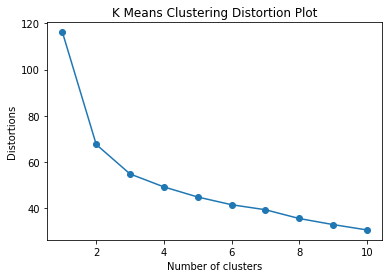

In [53]:
plot_kmeans_distortion_graph()

#### Analysis

In the experiment above the agglomerative and k means clustering algorithms were assessed to see how well defined the clusters were when varying different parameters. 

For the agglomerative clustering experiment the parameters varied were the number of clusters, the affinity and linkage.  The overall results from this experiment are shown above along with the mean validity indices per cluster number.  From these results can see that the best parameters that had the highest CHI score, the MSC closest to 1 and the lowest DBI score are:

    num_clusters = 2 
    linkage = average
    affinity = euclidean or manhattan 
    
When looking at the average CHI, MSC and DBI score for the varying number of clusters can see that 2 clusters are still the best with the highest CHI score and MSC score closest to 1.  


For the K means clustering experiment the parameters varied were the number of clusters and the algorithm being used.  The overall results from this experiment are shown above along with the mean validity indices per cluster number.  From these results can see that the best parameters that had the highest CHI score, the MSC closest to 1 and the lowest DBI score are:

    num_clusters = 2 
    algorithm = auto or elkan or full 
    
When looking at the average CHI, MSC and DBI score for the varying number of clusters can see that 2 clusters are still the best with the highest CHI score, MSC score closest to 1 and lowest DBI score.

For K means clustering the number of clusters were varied between 1 and 10 and the distortion function was measured and plotted.  This method is sometimes used to visually inspect the impact of the number of clusters and generally where it starts to plateau gives a good indication of the correct number of clusters.  In this case it is difficult to tell where the distortion function plateaus and although it starts decreasing less after 2 it's hard to tell if this would be a better value than 3 or 4. 

Overall though the validity results of both the agglomerative and k means experiment show that the best number of clusters is 2 and that is what I shall use in the next section.

### Performance Analysis of Clustering Techniques 

Using the cluster number that appeared to perform the best from the previous section the performance of hierarchical and K-means clustering is assessed.

In the next couple of cells the clusters are created and their distributions are analysed against the class labels from the original data (ALL and AML) to see how well both algorithms performed and the results are discussed.

In [54]:
def plot_cluster_distribution(final_data, clustering_method):
    """
        final_data: Pandas dataframe containing the clustered data 
                        along with class labels
        algorithm: String stating clustering
    """
    fig, ax =plt.subplots(1,2,figsize=(15,7))
    fig.suptitle('Histogram for ' + clustering_method + ' distributions')
    sns.histplot(data=final_data, x="Cluster_Label", discrete=True, ax=ax[0])
    sns.histplot(data=final_data, x="Class", discrete=True, ax=ax[1])
    ax[0].set_title('Cluster Distribution')
    ax[1].set_title('Class Label Distribution')
    fig.show()

def create_and_plot_final_agglomerative_cluster():
    """
        return: data which is a Pandas dataframe containing the 
                    clustered results
    """
    affinity_measure = 'euclidean'
    linkage_value = 'average'
    num_clusters = 2
    clustered_data = create_cluster(get_data(), num_clusters, 
                                    affinity_measure, 
                                    linkage_value) 
    plot_dendrogram(clustered_data, linkage_value)
    data = merge_cluster_data_with_class_labels(clustered_data)
    plot_cluster_distribution(data, 'agglomerative clustering')
    return data

def create_and_plot_final_kmeans_cluster():
    """
        return: data which is a Pandas dataframe containing the 
                    clustered results
    """
    algorithm = 'auto'
    num_clusters = 2
    clustered_data, inertia = create_kmeans_cluster(get_data(), 
                                                    num_clusters, 
                                                    algorithm) 
    data = merge_cluster_data_with_class_labels(clustered_data)
    plot_cluster_distribution(data, 'K means clustering')
    return data


def merge_cluster_data_with_class_labels(cluster_results_df):
    """
        cluster_results_df: Pandas dataframe containing the results 
                            from the clustering 
        
        return: cluster_results_df with the class column added back into 
                    the dataframe
    """
    orig_data = pd.read_csv('Data/leukaemia_samples.csv')
    cluster_results_df['Class'] = orig_data['Class']
    return cluster_results_df

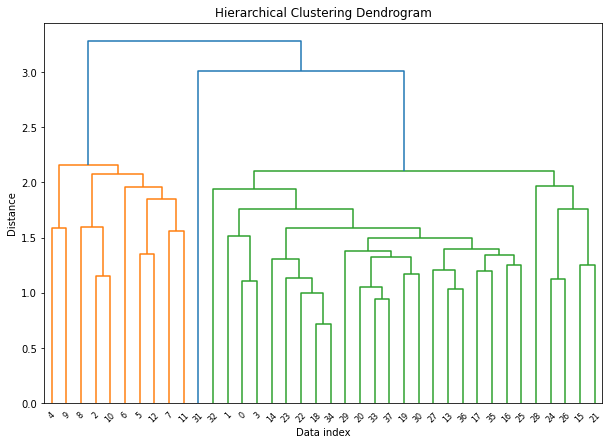

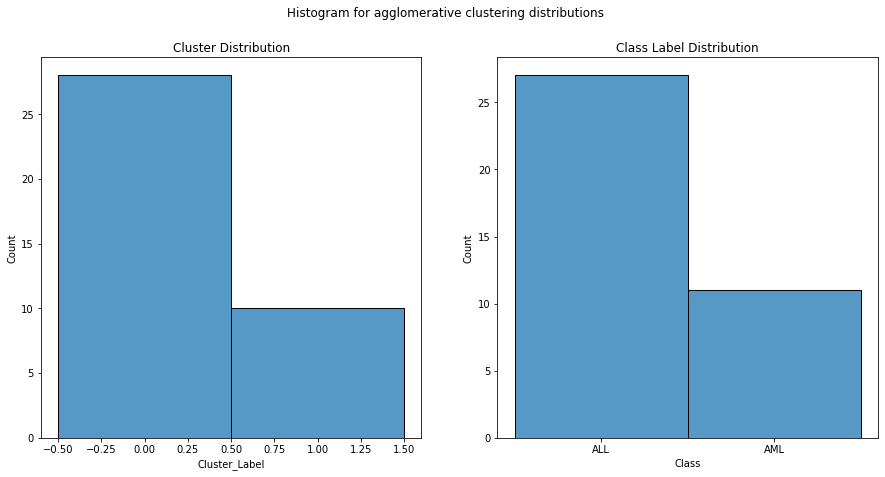

In [55]:
agg_cluster_final_df = create_and_plot_final_agglomerative_cluster()

In [56]:
print('Agglomerative Cluster Results')
agg_cluster_final_df[['Cluster_Label', 'Class']].sort_values(by=['Cluster_Label', 'Class']).head(40)

Agglomerative Cluster Results


Cluster_Label Class
0               0   ALL
1               0   ALL
13              0   ALL
14              0   ALL
15              0   ALL
16              0   ALL
17              0   ALL
18              0   ALL
19              0   ALL
20              0   ALL
21              0   ALL
22              0   ALL
23              0   ALL
24              0   ALL
25              0   ALL
26              0   ALL
27              0   ALL
28              0   ALL
29              0   ALL
30              0   ALL
31              0   ALL
32              0   ALL
33              0   ALL
34              0   ALL
35              0   ALL
36              0   ALL
37              0   ALL
3               0   AML
2               1   AML
4               1   AML
5               1   AML
6               1   AML
7               1   AML
8               1   AML
9               1   AML
10              1   AML
11              1   AML
12              1   AML

In [57]:
X = agg_cluster_final_df.drop(columns=['Cluster_Label', 'Class'])
print('Agglomerative Silhouette Score is ', 
      silhouette_score(X, agg_cluster_final_df['Cluster_Label']))
silhouette_values = silhouette_samples(X, agg_cluster_final_df['Cluster_Label']) 
print (silhouette_values)

Agglomerative Silhouette Score is  0.3900357480091599
[0.16151456 0.30189665 0.35259886 0.04371187 0.44906511 0.46509025
 0.23956645 0.23067288 0.30690138 0.44777289 0.26629848 0.32097867
 0.41711306 0.48834225 0.30876014 0.42780875 0.47247009 0.42603831
 0.4624157  0.38745559 0.43472008 0.43252966 0.41781093 0.48109579
 0.4804194  0.43060677 0.47716206 0.50467946 0.36550105 0.38871674
 0.44767866 0.35361416 0.40855032 0.37486453 0.45049893 0.47842374
 0.46992482 0.44808937]


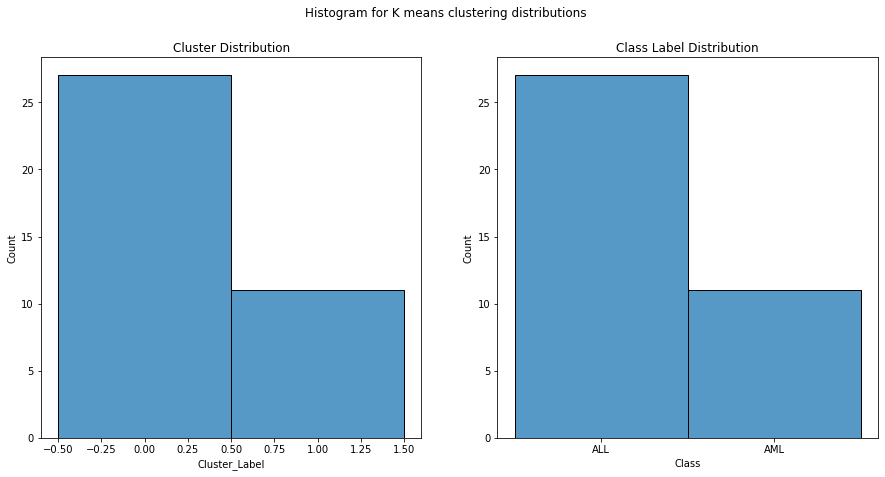

In [58]:
kmeans_cluster_final_df = create_and_plot_final_kmeans_cluster()

In [59]:
print('K Means Cluster Results')
kmeans_cluster_final_df[['Cluster_Label', 
                         'Class']].sort_values(by=['Cluster_Label', 
                                                   'Class']).head(40)

K Means Cluster Results


Cluster_Label Class
0               0   ALL
1               0   ALL
13              0   ALL
14              0   ALL
15              0   ALL
16              0   ALL
17              0   ALL
18              0   ALL
19              0   ALL
20              0   ALL
21              0   ALL
22              0   ALL
23              0   ALL
24              0   ALL
25              0   ALL
26              0   ALL
27              0   ALL
28              0   ALL
29              0   ALL
30              0   ALL
31              0   ALL
32              0   ALL
33              0   ALL
34              0   ALL
35              0   ALL
36              0   ALL
37              0   ALL
2               1   AML
3               1   AML
4               1   AML
5               1   AML
6               1   AML
7               1   AML
8               1   AML
9               1   AML
10              1   AML
11              1   AML
12              1   AML

In [60]:
X = kmeans_cluster_final_df.drop(columns=['Cluster_Label', 'Class'])
print('K Means Clustering Silhouette Score is ', 
      silhouette_score(X, kmeans_cluster_final_df['Cluster_Label']))
silhouette_values = silhouette_samples(X, kmeans_cluster_final_df['Cluster_Label']) 
print (silhouette_values)

K Means Clustering Silhouette Score is  0.37712234550734475
[ 0.10220546  0.27475648  0.36457104 -0.04371187  0.42885884  0.44621408
  0.25940937  0.2415491   0.31505512  0.43342936  0.29014524  0.32619613
  0.40430465  0.4809052   0.28762231  0.42159027  0.45906571  0.4167826
  0.4468462   0.36377241  0.40949986  0.43199818  0.39412102  0.47464749
  0.47957981  0.40969765  0.47870667  0.49782288  0.35886619  0.36212692
  0.42740918  0.35739163  0.40042591  0.34284753  0.43169521  0.47344811
  0.45802762  0.42276957]


#### Performance Analysis 

##### Agglomerative Clustering

The agglomerative clustering technique appears to have performed well as it got all but one data point in the correct cluster.  Looking at the table of results can see that cluster 0 refers to ALL class while cluster 1 refers to AML class.  Only one data point was misclassifed and this was the data point with index value of 3 which belongs to the AML class but was put into the cluster 0 which contains the ALL data points.  

##### K means Clustering

The K means clustering technique appears to have performed better than agglomerative as it managed to classify every single data point into the correct class with all 11 AML classes in cluster 1 while all 27 ALL classes are in cluster 0.  

The reason that K means clustering technique could have performed better than agglomerative clustering is that Kmeans assumes the clusters are spherical whereas agglomerative assumes the clusters are well separated.  The silhouette mean scores above for both algorithms are 3.77 (k means) and 3.9 (agglomerative) with a couple of the individual silhouette  values being close to 0.  This indicates that perhaps the clusters are not well enough separated which could be the reason agglomerative misclassified a result. 

From the dendrogram for this cluster it does look like data point 31 could be an outlier as it is not merged into a cluster until near the top of the tree.  This indicates that data point 31 lies quite far away from the other data points.  This could also explain the reason why one of the silhouette values is -0.04 for K means and 0.04 for agglomerative.  A silhouette value that is close to 0, indicates that this sample could be assigned to another cluster closest to it and also lies equally far away from the cluster it's assigned to and the neigbouring cluster. The majority of the other silhouette values are closer to the mean so this indicates that this data point is an outlier that overlaps both clusters. 


### References

https://scikit-learn.org/stable/modules/classes.html


https://seaborn.pydata.org/api.html

https://pandas.pydata.org/pandas-docs/stable/reference/index.html


https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html


https://www.geeksforgeeks.org/python-program-to-count-words-in-a-sentence/


https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d


https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/


https://docs.pymc.io/